# Simulating Transit Timing Variations for TRAPPIST-1 using REBOUND

In [ ]:
# Run this cell to install REBOUND.
!pip install rebound

## Setting up the TRAPPIST-1 System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# Primary Source - E. Agol et al. 2021
m_star = 0.09

# Start of simulation at BJD_TDB - 2,450,000 = 7257.93115525 days
start_t = (7257.93115525 * (2*np.pi/365.25))

# Planet masses
pl_m = np.array([4.596, 4.374, 1.297, 2.313, 3.475, 4.418, 1.088]) * ((1e-05) * m_star)

# Period and Transit time planet would have if it orbited a single body with a mass of the sum of the star 
# and the interior planets, unperturbed by the exterior planets
pl_P = np.array([1.510826, 2.421937, 4.049219, 6.101013, 9.207540, 12.352446, 18.772866]) * (2*np.pi/365.25)
pl_T = np.array([7257.55044, 7258.58728, 7257.06768, 7257.82771, 7257.07426, 7257.71462, 7249.60676]
               ) * (2*np.pi/365.25)

pl_ecos = np.array([-0.00215, 0.00055, -0.00496, 0.00433, -0.00840, 0.00380, -0.00365])
pl_esin = np.array([0.00217, 0.00001, 0.00267, -0.00461, -0.00051, 0.00128, -0.00002])
pl_e = np.sqrt((pl_ecos**2) + (pl_esin**2))
pl_omega = np.arctan2(pl_esin, pl_ecos) + np.pi/2

In [3]:
def init_planet(sim_start, mass_prior, m_target, period, trans_t, planet_e, planet_omega):
    sum_mass = m_star + np.sum(mass_prior)
    sim_temp = rebound.Simulation()
    sim_temp.t = trans_t
    sim_temp.add(m = sum_mass)
    sim_temp.add(m = m_target, e = planet_e, P  = period, omega = planet_omega, f = -planet_omega)
    sim_temp.move_to_com()
    sim_temp.integrate(sim_start)
    sim_temp.move_to_hel()
    return sim_temp.particles[1]

In [4]:
sim = rebound.Simulation()
sim.t = start_t
sim.add(m = m_star)
for i in range(len(pl_m)):
    sim.add(init_planet(start_t, pl_m[:i], pl_m[i], pl_P[i], pl_T[i], pl_e[i], pl_omega[i]))
    sim.move_to_com()

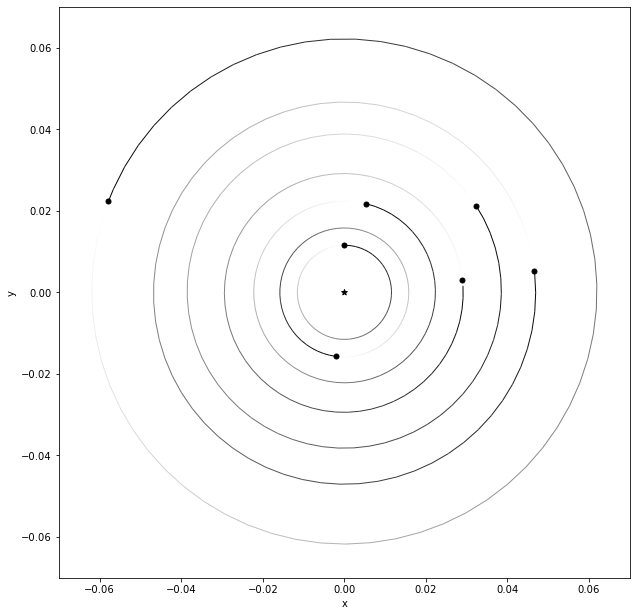

In [5]:
fig, ax = rebound.OrbitPlot(sim, xlim = [-0.07,0.07], ylim = [-0.07,0.07], periastron = not True)
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

## Plotting the radial velocity of the Red Dwarf with respect to time

The time period will be from BJD 2,457,600 to BJD 2,457,630.

In [6]:
time = np.linspace(7600*(2*np.pi/365.25), 7630*(2*np.pi/365.25), 1000)
vx = np.zeros(len(time))
vy = np.zeros(len(time))
vz = np.zeros(len(time))
for i in range(1000):
    sim.integrate(time[i])
    vx[i] = sim.particles[0].vx * 2 * np.pi * 4740.47
    vy[i] = sim.particles[0].vy * 2 * np.pi * 4740.47
    vz[i] = sim.particles[0].vz * 2 * np.pi * 4740.47

Text(0, 0.5, 'RV [m/s]')

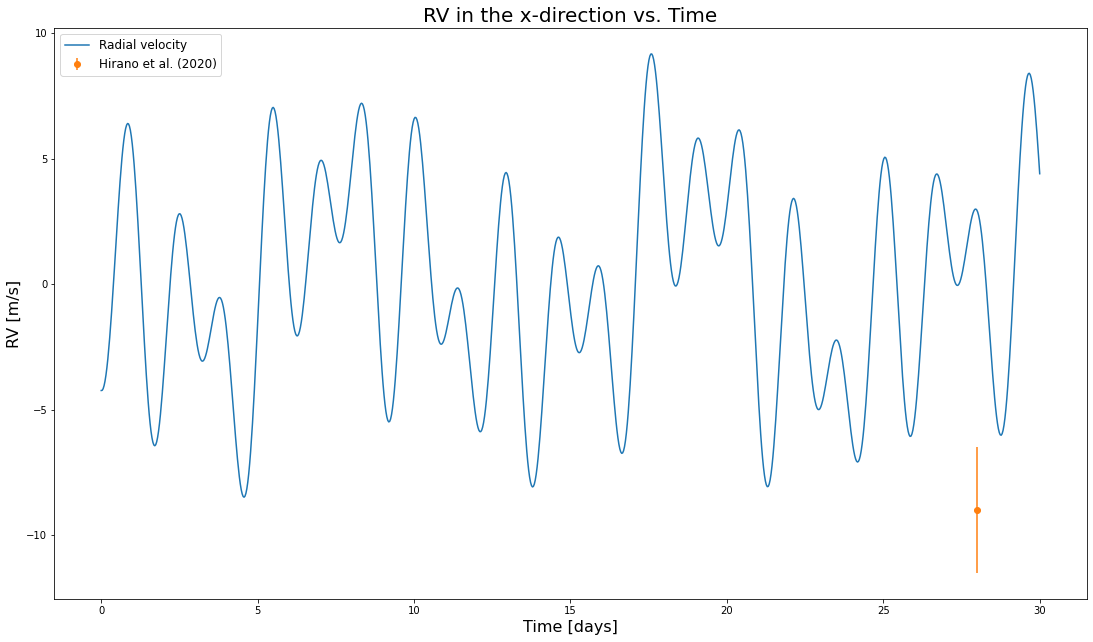

In [7]:
plt.plot((time/(2*np.pi/365.25))-7600, vx, label = "Radial velocity")
plt.errorbar(28,-9.0,2.5, label="Hirano et al. (2020)",fmt="o")
plt.legend(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("RV in the x-direction vs. Time", fontsize=20)
ax.set_xlabel("Time [days]", fontsize=16)
ax.set_ylabel("RV [m/s]", fontsize=16)

## Checking if the Transit times match

In [8]:
filename = 'observed_tt.txt'
# Observed transit times for each planet as reported in E. Agol 2021 in machine readable format in observed_tt.txt
observed_transits = {'b' : np.array([]), 
                     'c' : np.array([]), 
                     'd' : np.array([]), 
                     'e' : np.array([]), 
                     'f' : np.array([]),
                     'g' : np.array([]), 
                     'h' : np.array([])}
observed_transits_err = {'b' : np.array([]), 
                     'c' : np.array([]), 
                     'd' : np.array([]), 
                     'e' : np.array([]), 
                     'f' : np.array([]),
                     'g' : np.array([]), 
                     'h' : np.array([])}
with open(filename) as file:
    for line in file:
        line = line.strip().split(' ')
        line_filtered = []
        for i in range(len(line)):
            if line[i] != '':
                line_filtered.append(line[i])
        if line_filtered[0] in observed_transits.keys():
            observed_transits[line_filtered[0]] = np.append(observed_transits[line_filtered[0]], 
                                                           float(line_filtered[2]))
            observed_transits_err[line_filtered[0]] = np.append(observed_transits_err[line_filtered[0]], 
                                                           float(line_filtered[3]))

In [9]:
for planet in observed_transits.keys():
    print("Planet {} observed transit dates:".format(planet))
    print(observed_transits[planet])
    print("---------------------------------")

Planet b observed transit dates:
[7322.51531  7325.5391   7328.5586   7331.5816   7334.6048   7337.62644
 7340.6482   7345.18028  7361.79945  7364.82173  7440.36518  7452.45225
 7463.0284   7509.8646   7512.88731  7568.7888   7586.91824  7589.93922
 7599.0064   7602.02813  7612.60595  7615.6271   7624.69094  7645.844
 7651.88731  7653.39801  7654.90908  7656.419    7657.93134  7659.44144
 7660.95217  7662.46367  7663.975297 7665.48546  7666.99561  7668.50666
 7670.01775  7671.52791  7679.082639 7682.10451  7721.38747  7739.517699
 7741.027871 7742.539178 7744.050894 7745.561639 7747.07208  7748.584465
 7750.093872 7751.60535  7753.116227 7754.628042 7756.13856  7757.648398
 7759.159533 7760.671124 7762.181196 7763.692207 7765.202976 7766.714792
 7768.225136 7769.737043 7771.247782 7772.757384 7774.268414 7775.779949
 7777.288995 7778.801182 7780.312968 7781.822306 7783.334098 7784.843722
 7792.399786 7793.90955  7795.419875 7796.931341 7798.442107 7799.953195
 7801.463137 7802.97559  7

### Planet b

In [10]:
time1 = np.linspace((observed_transits['b'][107] - 2) * (2*np.pi/365.25), 
                   (observed_transits['b'][107] + 2) * (2*np.pi/365.25), 1000)
xyz1 = np.zeros((len(time1), 3))
for i in range(len(time1)):
    sim.integrate(time1[i])
    xyz1[i] = np.array(sim.particles[1].xyz)

Text(0.5, 1.0, 'Motion of planet b in y-direction')

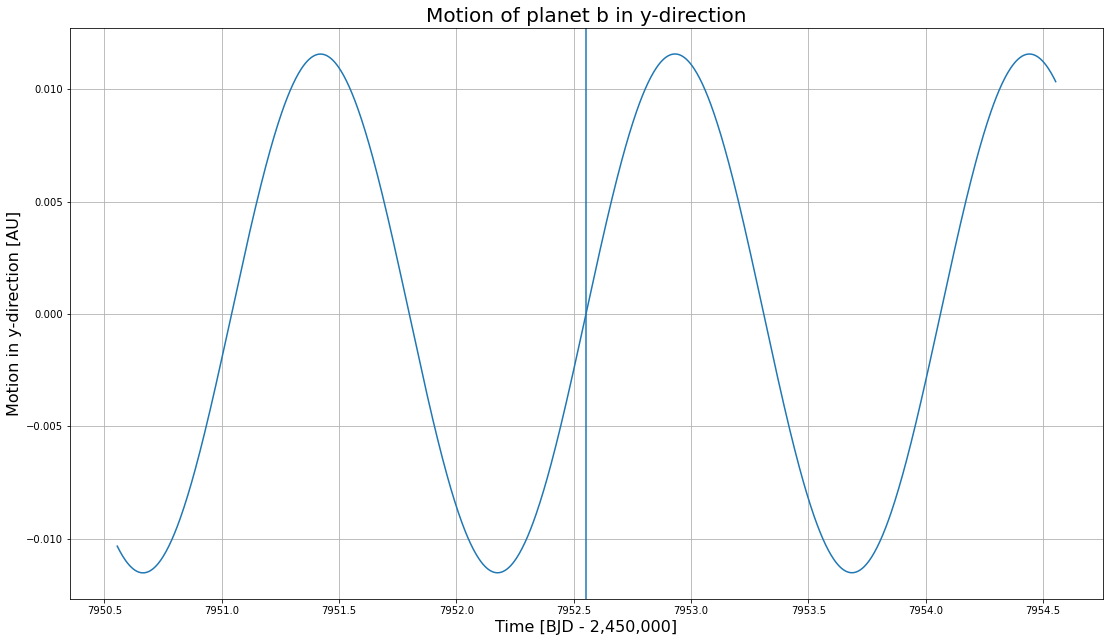

In [11]:
plt.plot(time1/(2*np.pi/365.25), xyz1[:,1])
plt.axvline(observed_transits['b'][107])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlabel("Time [BJD - 2,450,000]", fontsize=16)
ax.set_ylabel("Motion in y-direction [AU]", fontsize=16)
ax.set_title("Motion of planet b in y-direction", fontsize = 20)

### Planet c

In [12]:
time2 = np.linspace((observed_transits['c'][106] - 2) * (2*np.pi/365.25), 
                   (observed_transits['c'][106] + 2) * (2*np.pi/365.25), 1000)
xyz2 = np.zeros((len(time2), 3))
for i in range(len(time2)):
    sim.integrate(time2[i])
    xyz2[i] = np.array(sim.particles[2].xyz)

Text(0.5, 1.0, 'Motion of planet c in y-direction')

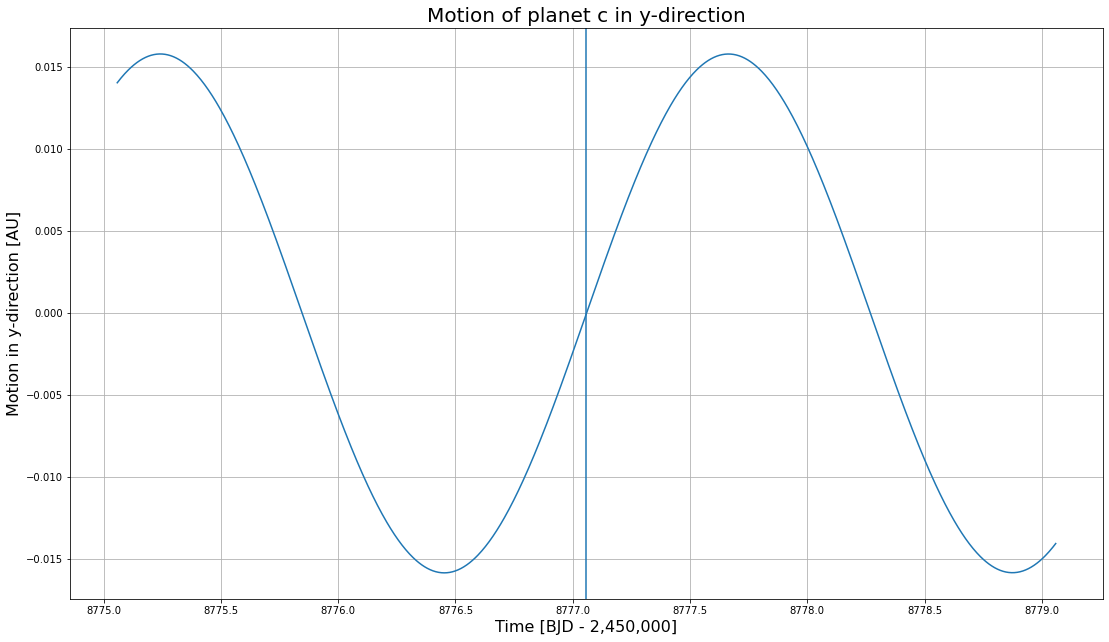

In [13]:
plt.plot(time2/(2*np.pi/365.25), xyz2[:, 1])
plt.axvline(observed_transits['c'][106])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlabel("Time [BJD - 2,450,000]", fontsize=16)
ax.set_ylabel("Motion in y-direction [AU]", fontsize=16)
ax.set_title("Motion of planet c in y-direction", fontsize = 20)

### Planet d

In [14]:
time3 = np.linspace((observed_transits['d'][7] - 5) * (2*np.pi/365.25), 
                   (observed_transits['d'][7] + 5) * (2*np.pi/365.25), 1000)
xyz3 = np.zeros((len(time3), 3))
for i in range(len(time3)):
    sim.integrate(time3[i])
    xyz3[i] = np.array(sim.particles[3].xyz)

Text(0.5, 1.0, 'Motion of planet d in y-direction')

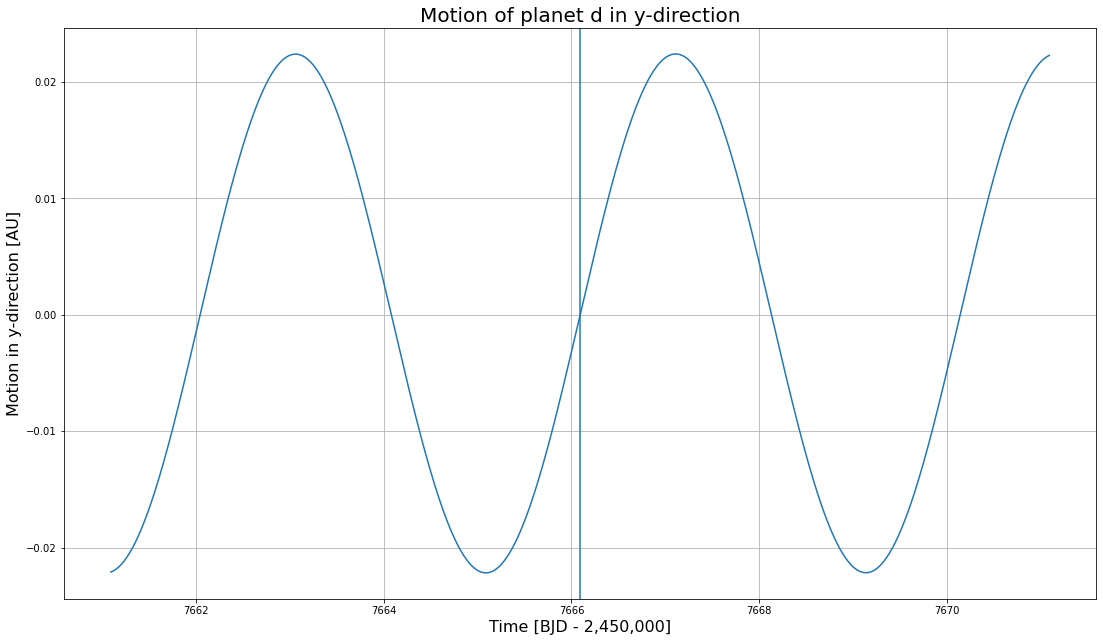

In [15]:
plt.plot(time3/(2*np.pi/365.25), xyz3[:,1])
plt.axvline(observed_transits['d'][7])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlabel("Time [BJD - 2,450,000]", fontsize=16)
ax.set_ylabel("Motion in y-direction [AU]", fontsize=16)
ax.set_title("Motion of planet d in y-direction", fontsize = 20)

### Planet e

In [16]:
time4 = np.linspace((observed_transits['e'][0] - 7) * (2*np.pi/365.25), 
                   (observed_transits['e'][0] + 7) * (2*np.pi/365.25), 1000)
xyz4 = np.zeros((len(time4), 3))
for i in range(len(time4)):
    sim.integrate(time4[i])
    xyz4[i] = np.array(sim.particles[4].xyz)

Text(0.5, 1.0, 'Motion of planet e in y-direction')

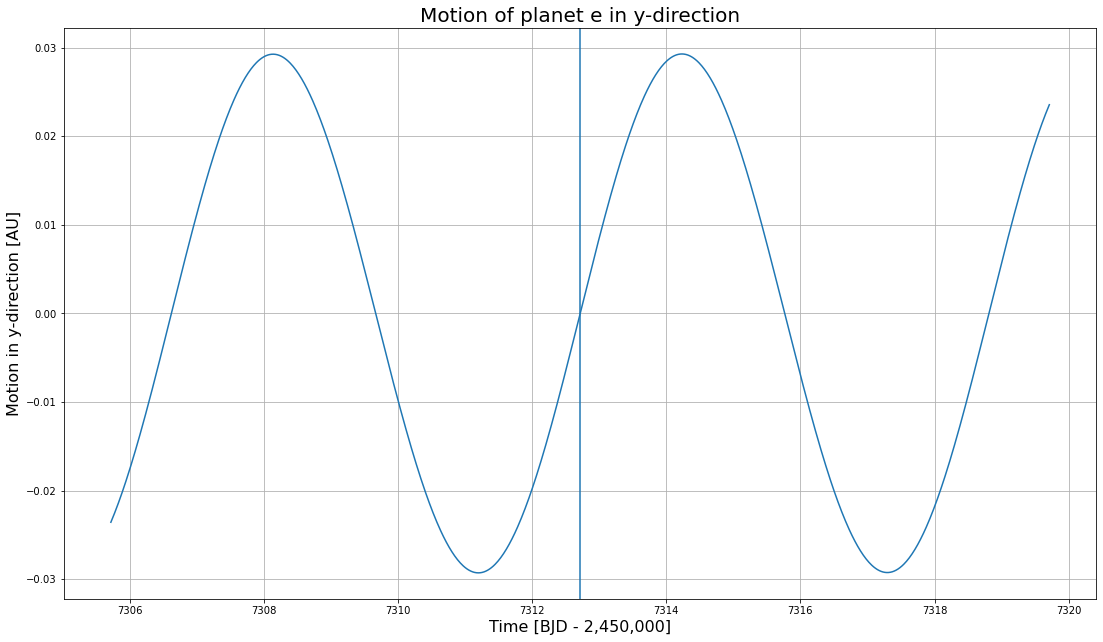

In [17]:
plt.plot(time4/(2*np.pi/365.25), xyz4[:, 1])
plt.axvline(observed_transits['e'][0])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlabel("Time [BJD - 2,450,000]", fontsize=16)
ax.set_ylabel("Motion in y-direction [AU]", fontsize=16)
ax.set_title("Motion of planet e in y-direction", fontsize = 20)

### Planet f

In [18]:
time5 = np.linspace((observed_transits['f'][0] - 7) * (2*np.pi/365.25), 
                   (observed_transits['f'][0] + 7) * (2*np.pi/365.25), 1000)
xyz5 = np.zeros((len(time5), 3))
for i in range(len(time5)):
    sim.integrate(time5[i])
    xyz5[i] = np.array(sim.particles[5].xyz)

Text(0.5, 1.0, 'Motion of planet f in y-direction')

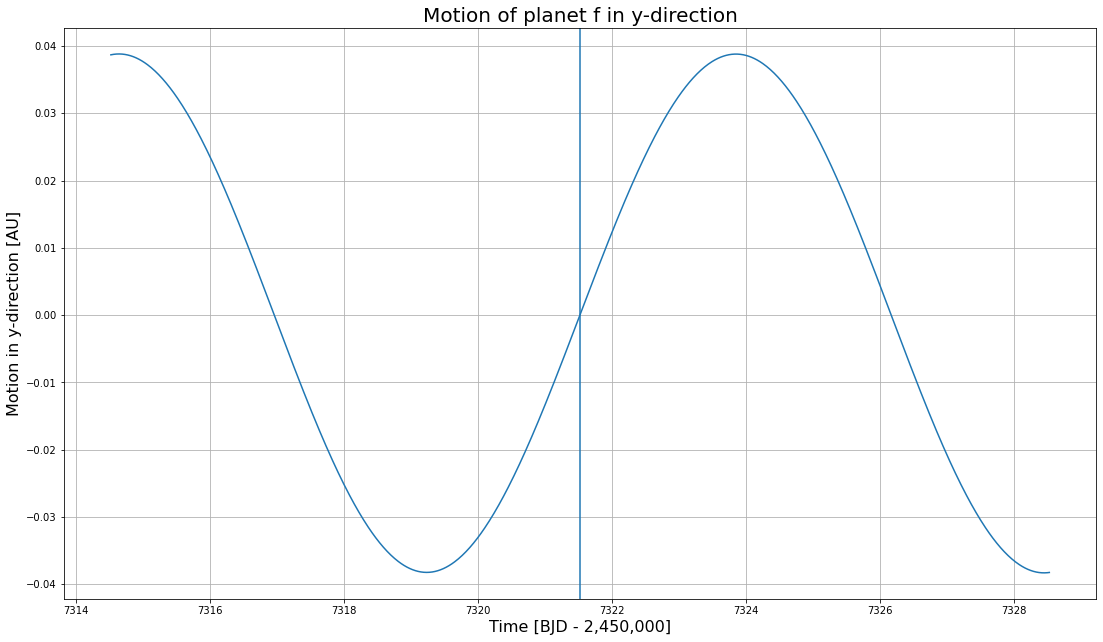

In [19]:
plt.plot(time5/(2*np.pi/365.25), xyz5[:,1])
plt.axvline(observed_transits['f'][0])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlabel("Time [BJD - 2,450,000]", fontsize=16)
ax.set_ylabel("Motion in y-direction [AU]", fontsize=16)
ax.set_title("Motion of planet f in y-direction", fontsize = 20)

### Planet g

In [20]:
time6 = np.linspace((observed_transits['g'][0] - 20) * (2*np.pi/365.25), 
                   (observed_transits['g'][0] + 20) * (2*np.pi/365.25), 1000)
xyz6 = np.zeros((len(time6), 3))
for i in range(len(time6)):
    sim.integrate(time6[i])
    xyz6[i] = np.array(sim.particles[6].xyz)

Text(0.5, 1.0, 'Motion of planet g in y-direction')

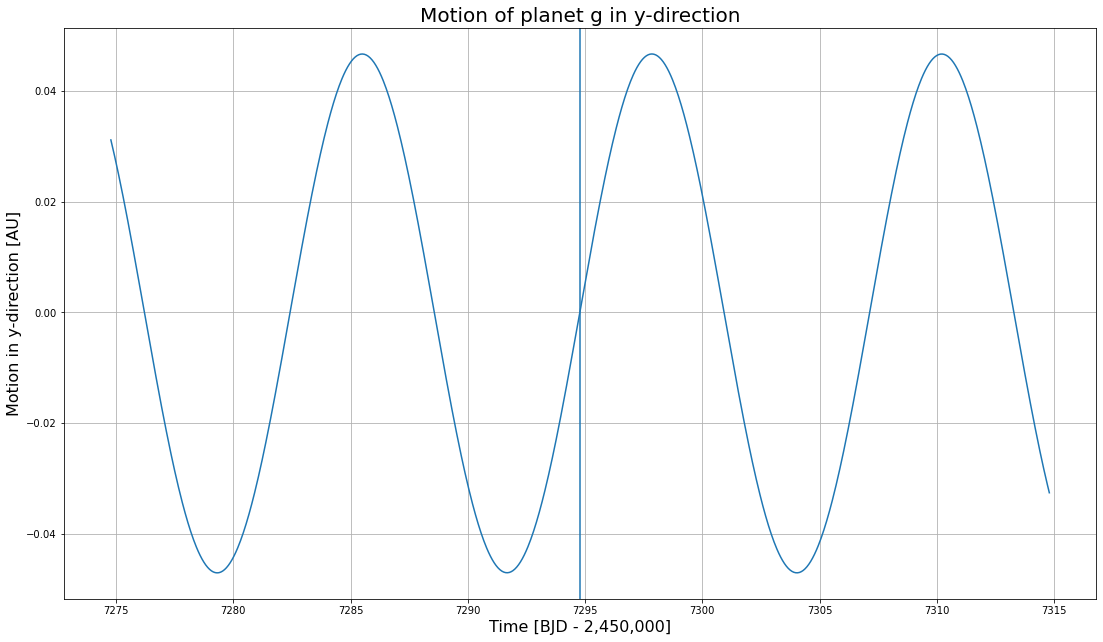

In [21]:
plt.plot(time6/(2*np.pi/365.25), xyz6[:, 1])
plt.axvline(observed_transits['g'][0])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlabel("Time [BJD - 2,450,000]", fontsize=16)
ax.set_ylabel("Motion in y-direction [AU]", fontsize=16)
ax.set_title("Motion of planet g in y-direction", fontsize = 20)

### Planet h

In [22]:
time7 = np.linspace((observed_transits['h'][0] - 20) * (2*np.pi/365.25), 
                   (observed_transits['h'][0] + 20) * (2*np.pi/365.25), 1000)
xyz7 = np.zeros((len(time7), 3))
for i in range(len(time7)):
    sim.integrate(time7[i])
    xyz7[i] = np.array(sim.particles[7].xyz)

Text(0.5, 1.0, 'Motion of planet h in y-direction')

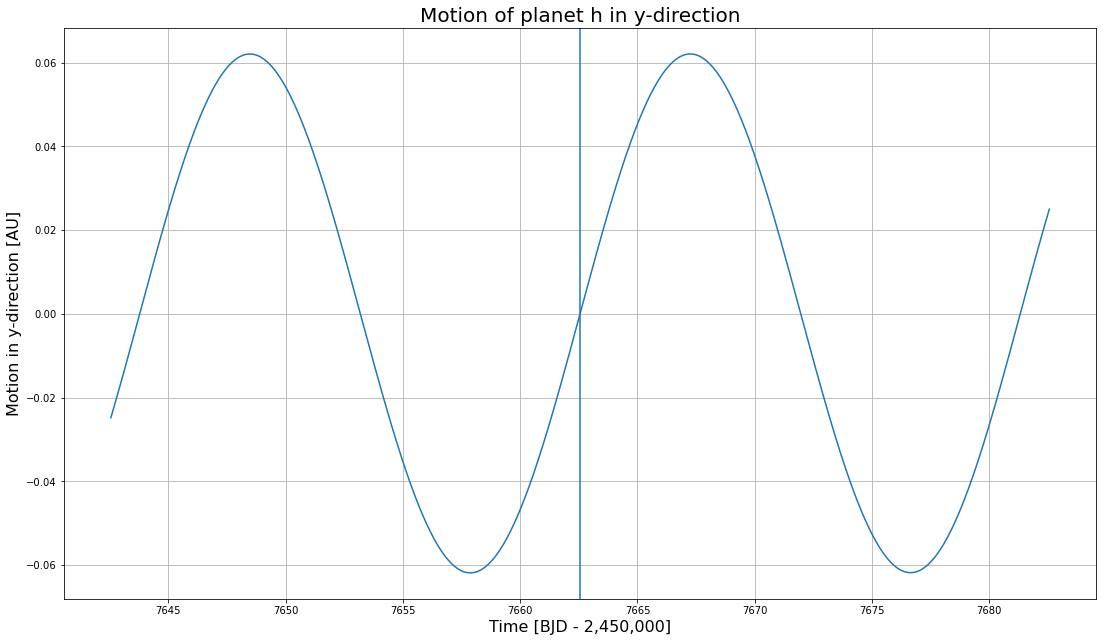

In [23]:
plt.plot(time7/(2*np.pi/365.25), xyz7[:, 1])
plt.axvline(observed_transits['h'][0])
plt.grid()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_xlabel("Time [BJD - 2,450,000]", fontsize=16)
ax.set_ylabel("Motion in y-direction [AU]", fontsize=16)
ax.set_title("Motion of planet h in y-direction", fontsize = 20)

## Simulating Transit Times

### Time-step = 0.06 days

In [24]:
simulated_transits = {'b' : np.array([]), 
                      'c' : np.array([]), 
                      'd' : np.array([]), 
                      'e' : np.array([]), 
                      'f' : np.array([]),
                      'g' : np.array([]), 
                      'h' : np.array([])}
key_index = {'b': 1,
             'c': 2,
             'd': 3,
             'e': 4,
             'f': 5,
             'g': 6,
             'h': 7}

for key in simulated_transits.keys():
    sim_start = (observed_transits[key][0] - 0.2) * (2*np.pi/365.25)
    transittimes = np.zeros(1 + round((observed_transits[key][len(observed_transits[key])-1] - 
                                       observed_transits[key][0])/(pl_P[key_index[key]-1]/(2*np.pi/365.25))))
    sim.integrate(sim_start)
    p = sim.particles
    i = 0
    while i < len(transittimes):
        y_old = p[key_index[key]].y - p[0].y 
        t_old = sim.t
        sim.integrate(sim.t + (0.06*(2*np.pi/365.25))) 
        t_new = sim.t
        if y_old*(p[key_index[key]].y - p[0].y) < 0. and p[key_index[key]].x - p[0].x > 0.:   
            # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new - t_old > 1e-07:
                if y_old*(p[key_index[key]].y - p[0].y) < 0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate((t_new + t_old)/2.)
            transittimes[i] = sim.t
            i += 1
            sim.integrate(sim.t + (0.06*(2*np.pi/365.25)))
    simulated_transits[key] = transittimes

In [25]:
for planet in simulated_transits.keys():
    simulated_transits[planet] = simulated_transits[planet]/(2*np.pi/365.25)
    print("Planet {} Simulated transit dates:".format(planet))
    print(simulated_transits[planet])
    print("---------------------------------")

Planet b Simulated transit dates:
[7322.51788507 7324.02849604 7325.53915094 7327.05001459 7328.56116754
 7330.0718371  7331.58255426 7333.09390863 7334.60476496 7336.11538324
 7337.62601618 7339.13686884 7340.64808039 7342.15876459 7343.66947077
 7345.18078119 7346.6916485  7348.20226679 7349.71288507 7351.22373407
 7352.73500055 7354.2456994  7355.75639826 7357.26765375 7358.77852472
 7360.28915399 7361.79976496 7363.31061029 7364.82192804 7366.33263788
 7367.84332575 7369.35452631 7370.86540094 7372.37605219 7373.88665949
 7375.3974975  7376.90885553 7378.41958368 7379.9302569  7381.44140253
 7382.95228449 7384.46295404 7385.97356134 7387.48439203 7388.99578668
 7390.50652948 7392.01719904 7393.52828241 7395.03916071 7396.54986689
 7398.06047419 7399.57129755 7401.08272516 7402.59348261 7404.10413752
 7405.61515863 7407.12604059 7408.63678339 7410.14740534 7411.65821772
 7413.16965998 7414.68043573 7416.19108332 7417.70204218 7419.21292414
 7420.72371454 7422.23434015 7423.74514154 

Text(0.5, 0, 'Number of Transits')

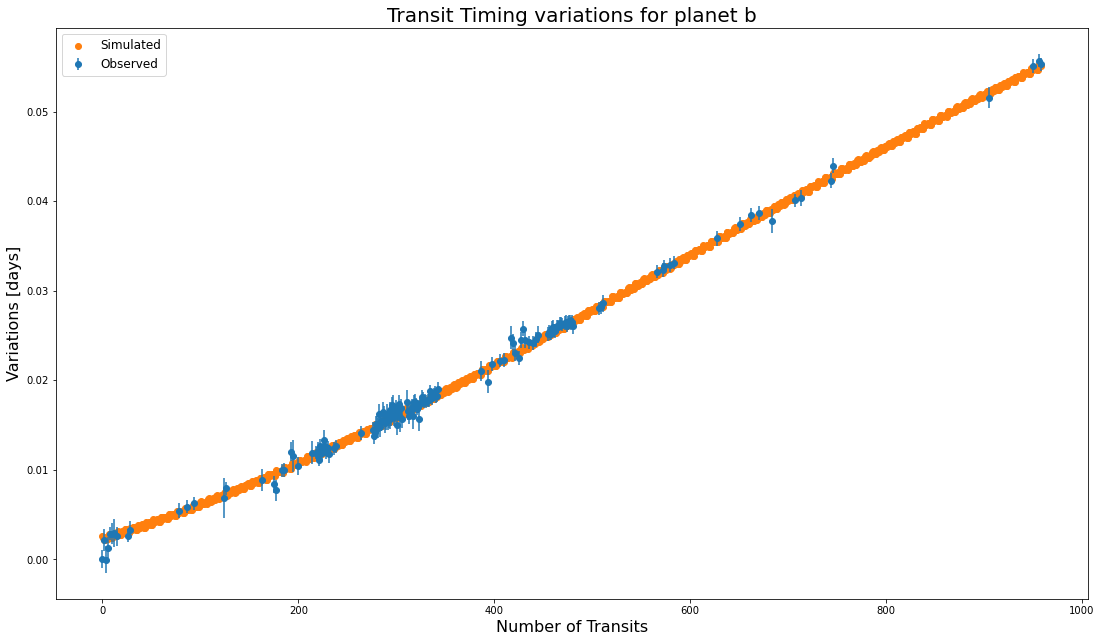

In [26]:
err_b = np.sqrt(observed_transits_err['b']**2 + observed_transits_err['b'][0]**2)
plt.errorbar(np.around((observed_transits['b'] - observed_transits['b'][0])/1.510826), 
            observed_transits['b'] - observed_transits['b'][0] - 
            (np.around((observed_transits['b'] - observed_transits['b'][0])/1.510826)*(1.510826)),
            yerr = err_b, fmt = 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits['b'])), 
            simulated_transits['b'] - observed_transits['b'][0] - 
            (np.arange(0, len(simulated_transits['b']))*(1.510826)), color='C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet b", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

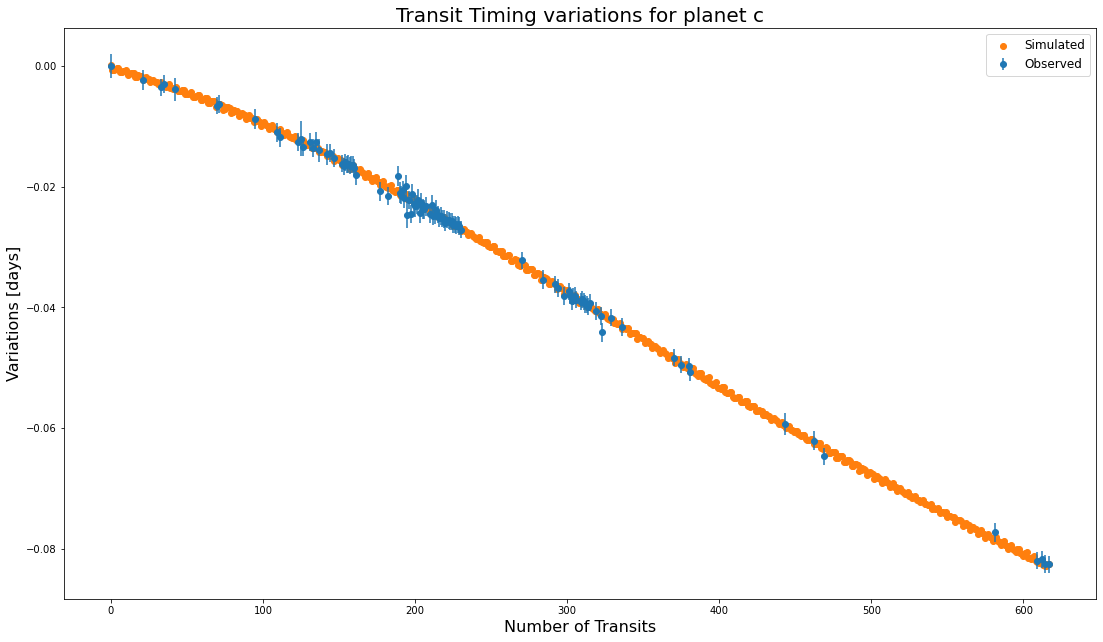

In [27]:
err_c = np.sqrt(observed_transits_err['c']**2 + observed_transits_err['c'][0]**2)
plt.errorbar(np.around((observed_transits['c'] - observed_transits['c'][0])/2.421937), 
            observed_transits['c'] - observed_transits['c'][0] - 
            (np.around((observed_transits['c'] - observed_transits['c'][0])/2.421937)*(2.421937)),
            yerr = err_c, fmt = 'o', label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['c'])), 
            simulated_transits['c'] - observed_transits['c'][0] - 
            (np.arange(0, len(simulated_transits['c']))*(2.421937)), color='C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet c", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

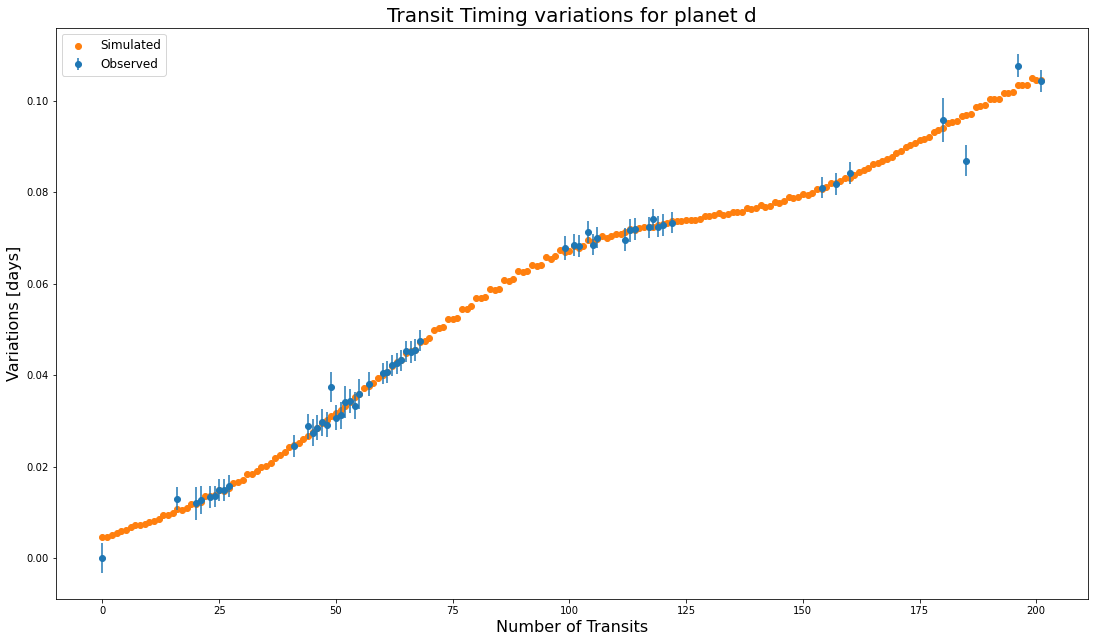

In [28]:
err_d = np.sqrt(observed_transits_err['d']**2 + observed_transits_err['d'][0]**2)
plt.errorbar(np.around((observed_transits['d'] - observed_transits['d'][0])/4.049219), 
            observed_transits['d'] - observed_transits['d'][0] - 
            (np.around((observed_transits['d'] - observed_transits['d'][0])/4.049219)*(4.049219)), 
            fmt = 'o', yerr= err_d, label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits['d'])), 
            simulated_transits['d'] - observed_transits['d'][0] - 
            (np.arange(0, len(simulated_transits['d']))*(4.049219)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet d", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

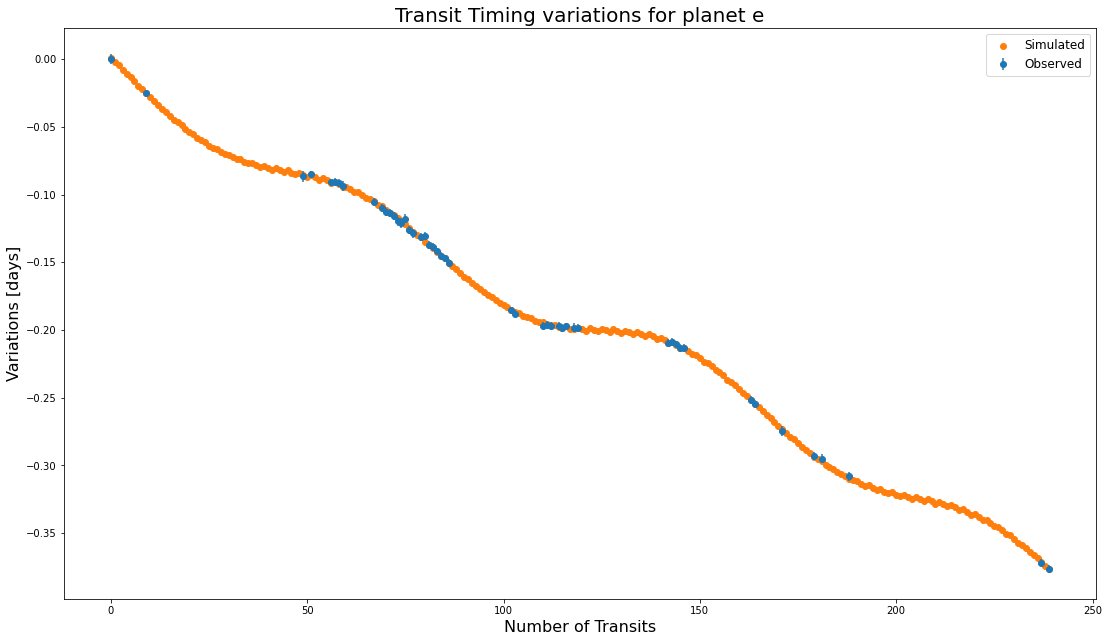

In [29]:
err_e = np.sqrt(observed_transits_err['e']**2 + observed_transits_err['e'][0]**2)
plt.errorbar(np.around((observed_transits['e'] - observed_transits['e'][0])/6.101013), 
            observed_transits['e'] - observed_transits['e'][0] - 
            (np.around((observed_transits['e'] - observed_transits['e'][0])/6.101013)*(6.101013)),
            yerr = err_e, fmt='o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits['e'])), 
            simulated_transits['e'] - observed_transits['e'][0] - 
            (np.arange(0, len(simulated_transits['e']))*(6.101013)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet e", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

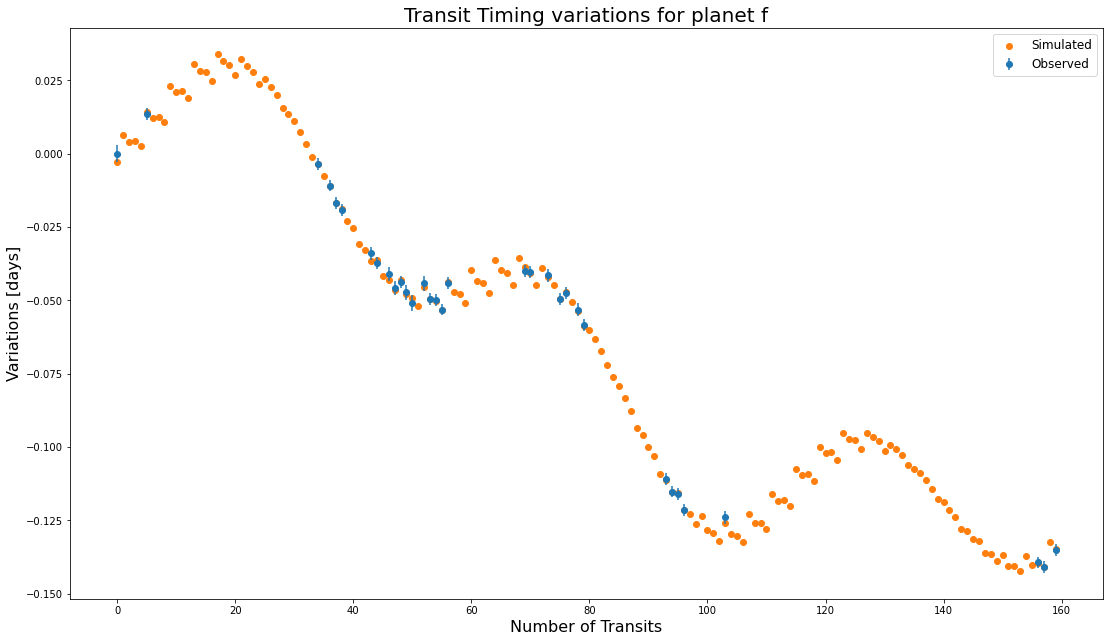

In [30]:
err_f = np.sqrt(observed_transits_err['f']**2 + observed_transits_err['f'][0]**2)
plt.errorbar(np.around((observed_transits['f'] - observed_transits['f'][0])/9.207540), 
            observed_transits['f'] - observed_transits['f'][0] - 
            (np.around((observed_transits['f'] - observed_transits['f'][0])/9.207540)*(9.207540)),
            yerr = err_f, fmt= 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits['f'])), 
            simulated_transits['f'] - observed_transits['f'][0] - 
            (np.arange(0, len(simulated_transits['f']))*(9.207540)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet f", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

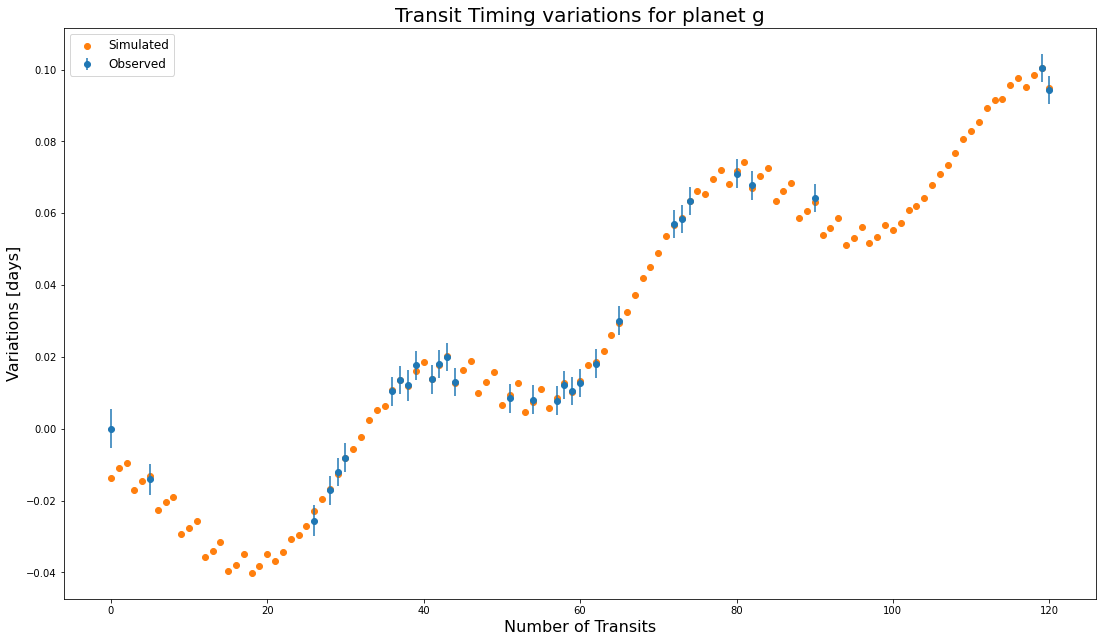

In [31]:
err_g = np.sqrt(observed_transits_err['g']**2 + observed_transits_err['g'][0]**2)
plt.errorbar(np.around((observed_transits['g'] - observed_transits['g'][0])/12.352446), 
            observed_transits['g'] - observed_transits['g'][0] - 
            (np.around((observed_transits['g'] - observed_transits['g'][0])/12.352446)*(12.352446)),
            yerr = err_g, fmt = 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits['g'])), 
            simulated_transits['g'] - observed_transits['g'][0] - 
            (np.arange(0, len(simulated_transits['g']))*(12.352446)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet g", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

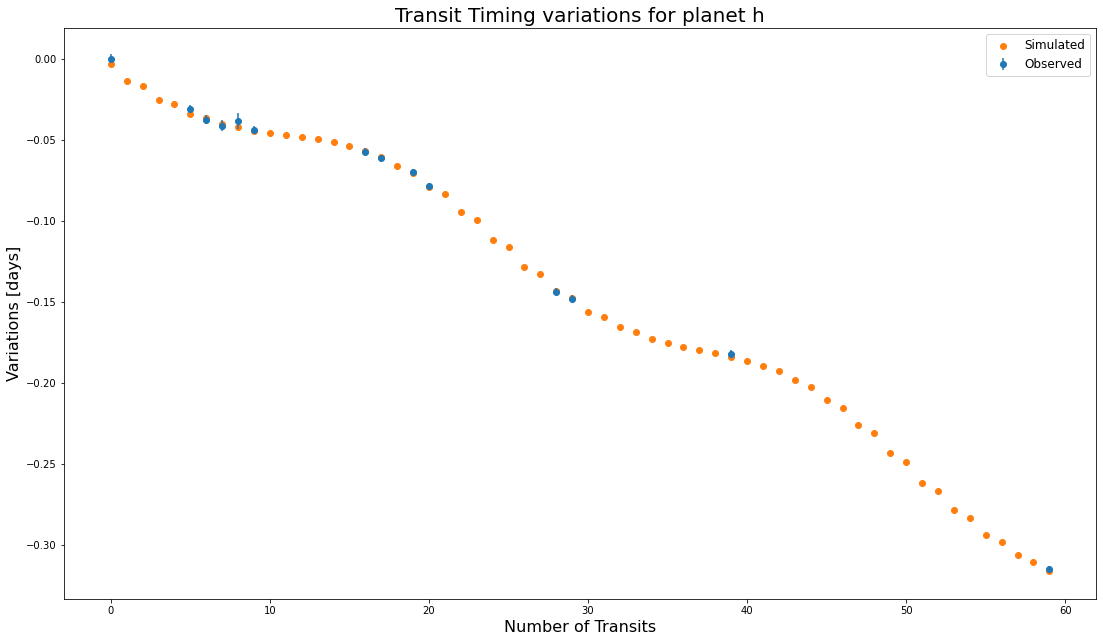

In [32]:
err_h = np.sqrt(observed_transits_err['h']**2 + observed_transits_err['h'][0]**2)
plt.errorbar(np.around((observed_transits['h'] - observed_transits['h'][0])/18.772866), 
            observed_transits['h'] - observed_transits['h'][0] - 
            (np.around((observed_transits['h'] - observed_transits['h'][0])/18.772866)*(18.772866)),
            yerr = err_h, fmt = 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits['h'])), 
            simulated_transits['h'] - observed_transits['h'][0] - 
            (np.arange(0, len(simulated_transits['h']))*(18.772866)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet h", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

In [33]:
for key in simulated_transits.keys():
    print((simulated_transits[key][0] - observed_transits[key][0]) * 24 * 60) # difference in minutes

3.708105473779142
0.20654297215514816
6.550488286593463
1.3139648479409516
-4.096582028578268
-19.84306640588329
-5.061621095373994


### Timestep = 0.0005 yr/2$\pi \approx$ 0.03 days

In [34]:
simulated_transits2 = {'b' : np.array([]), 
                      'c' : np.array([]), 
                      'd' : np.array([]), 
                      'e' : np.array([]), 
                      'f' : np.array([]),
                      'g' : np.array([]), 
                      'h' : np.array([])}

for key in simulated_transits2.keys():
    sim_start = (observed_transits[key][0] - 0.2) * (2*np.pi/365.25)
    transittimes = np.zeros(1 + round((observed_transits[key][len(observed_transits[key])-1] - 
                                       observed_transits[key][0])/(pl_P[key_index[key] - 1]/(2*np.pi/365.25))))
    sim.integrate(sim_start)
    p = sim.particles
    i = 0
    while i < len(transittimes):
        y_old = p[key_index[key]].y - p[0].y
        t_old = sim.t
        sim.integrate(sim.t + 0.0005) # check for transits every 0.0005 time units.
        t_new = sim.t
        if y_old*(p[key_index[key]].y - p[0].y) < 0. and p[key_index[key]].x - p[0].x > 0.:   
            # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new - t_old > 1e-7:
                if y_old*(p[key_index[key]].y - p[0].y) < 0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate((t_new + t_old)/2.)
            transittimes[i] = sim.t
            i += 1
            sim.integrate(sim.t + 0.0005)
    simulated_transits2[key] = transittimes

In [35]:
for planet in simulated_transits2.keys():
    simulated_transits2[planet] = simulated_transits2[planet]/(2*np.pi/365.25)
    print("Planet {} Simulated transit dates:".format(planet))
    print(simulated_transits2[planet])
    print("---------------------------------")

Planet b Simulated transit dates:
[7322.51788446 7324.02849574 7325.53915315 7327.05001634 7328.56116693
 7330.07183853 7331.58255626 7333.09390908 7334.60476518 7336.11538356
 7337.62601613 7339.13687223 7340.64807958 7342.15876537 7343.66946891
 7345.1807827  7346.6916459  7348.20226783 7349.7128862  7351.22373521
 7352.73499933 7354.24569931 7355.75639575 7357.26765633 7358.77852662
 7360.28915564 7361.79976337 7363.31061238 7364.82192617 7366.33264035
 7367.84332259 7369.3545264  7370.86540379 7372.3760541  7373.88666183
 7375.39749664 7376.90885302 7378.41958139 7379.93025653 7381.44140357
 7382.95228451 7384.46295611 7385.97356384 7387.48439156 7388.99578696
 7390.50652952 7392.01719757 7393.52828074 7395.03916168 7396.54986521
 7398.06047649 7399.57129711 7401.08272445 7402.59348475 7404.10413861
 7405.61516146 7407.12603885 7408.63678496 7410.14740334 7411.65821686
 7413.16966193 7414.68043643 7416.19108319 7417.70204218 7419.21292667
 7420.72371535 7422.23434083 7423.7451437  

Text(0.5, 0, 'Number of Transits')

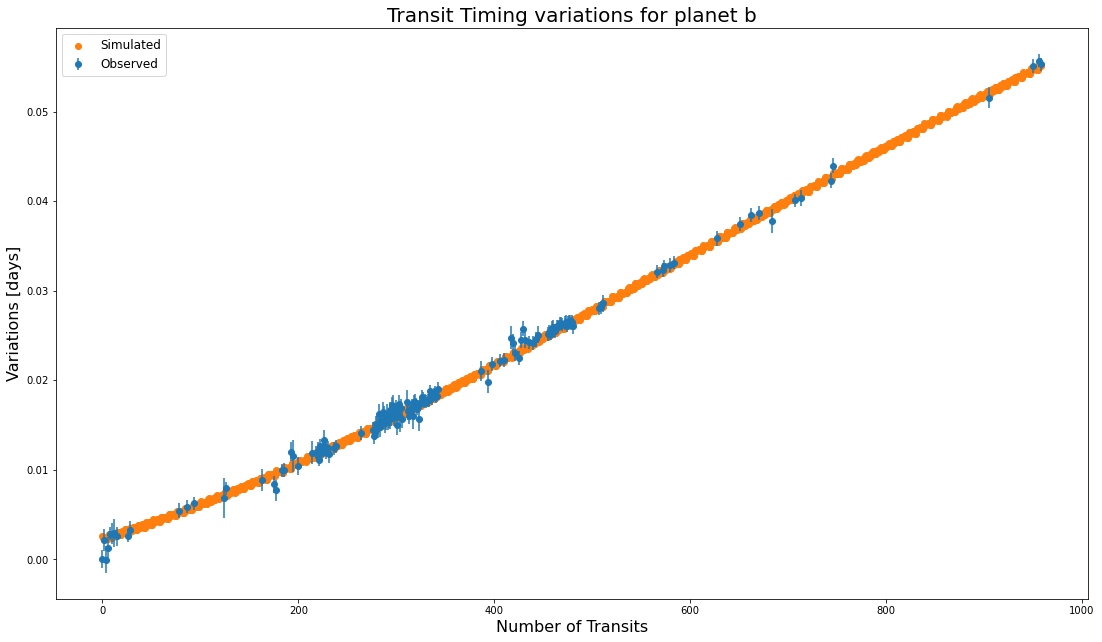

In [36]:
err_b = np.sqrt(observed_transits_err['b']**2 + observed_transits_err['b'][0]**2)
plt.errorbar(np.around((observed_transits['b'] - observed_transits['b'][0])/1.510826), 
            observed_transits['b'] - observed_transits['b'][0] - 
            (np.around((observed_transits['b'] - observed_transits['b'][0])/1.510826)*(1.510826)),
            yerr = err_b, fmt = 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits2['b'])), 
            simulated_transits2['b'] - observed_transits['b'][0] - 
            (np.arange(0, len(simulated_transits2['b']))*(1.510826)), color='C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet b", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

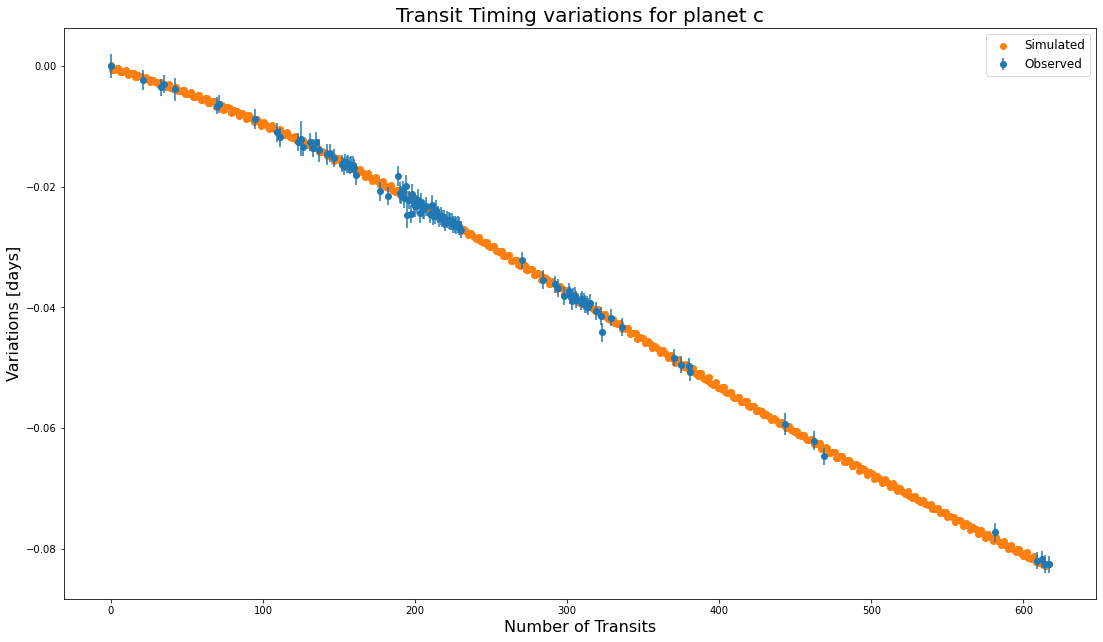

In [37]:
err_c = np.sqrt(observed_transits_err['c']**2 + observed_transits_err['c'][0]**2)
plt.errorbar(np.around((observed_transits['c'] - observed_transits['c'][0])/2.421937), 
            observed_transits['c'] - observed_transits['c'][0] - 
            (np.around((observed_transits['c'] - observed_transits['c'][0])/2.421937)*(2.421937)),
            yerr = err_c, fmt = 'o', label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits2['c'])), 
            simulated_transits2['c'] - observed_transits['c'][0] - 
            (np.arange(0, len(simulated_transits2['c']))*(2.421937)), color='C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet c", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

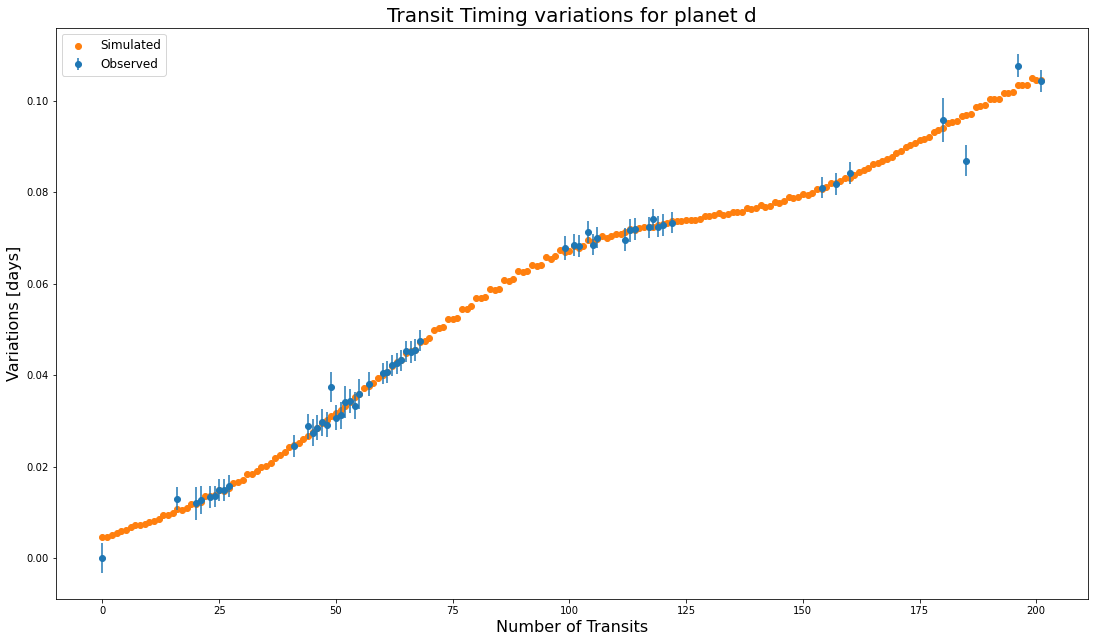

In [38]:
err_d = np.sqrt(observed_transits_err['d']**2 + observed_transits_err['d'][0]**2)
plt.errorbar(np.around((observed_transits['d'] - observed_transits['d'][0])/4.049219), 
            observed_transits['d'] - observed_transits['d'][0] - 
            (np.around((observed_transits['d'] - observed_transits['d'][0])/4.049219)*(4.049219)), 
            fmt = 'o', yerr= err_d, label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits2['d'])), 
            simulated_transits2['d'] - observed_transits['d'][0] - 
            (np.arange(0, len(simulated_transits2['d']))*(4.049219)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet d", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

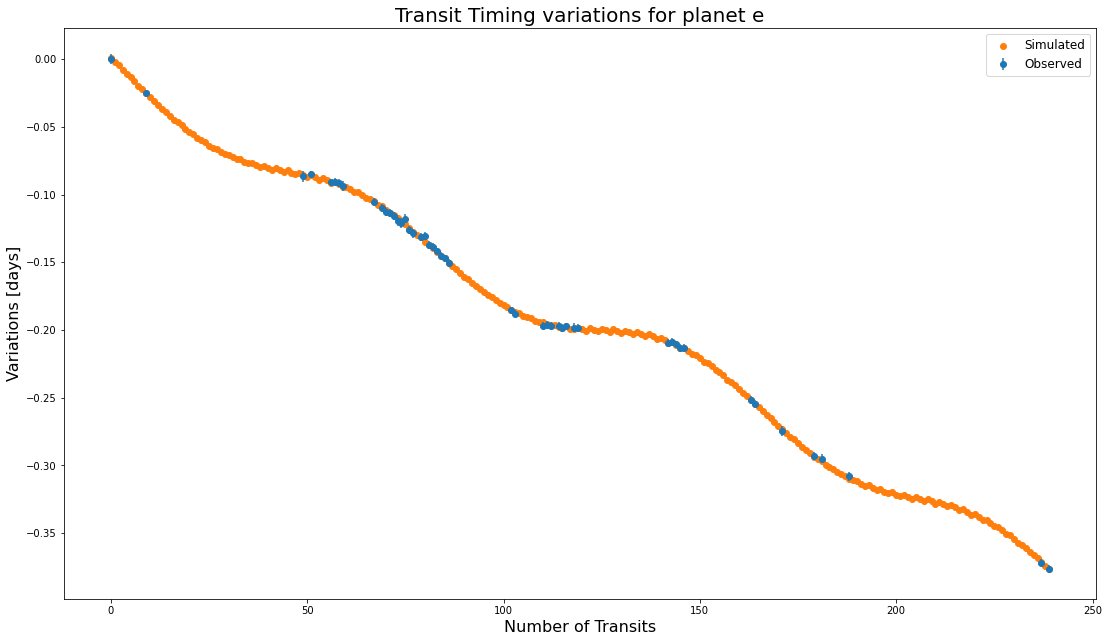

In [39]:
err_e = np.sqrt(observed_transits_err['e']**2 + observed_transits_err['e'][0]**2)
plt.errorbar(np.around((observed_transits['e'] - observed_transits['e'][0])/6.101013), 
            observed_transits['e'] - observed_transits['e'][0] - 
            (np.around((observed_transits['e'] - observed_transits['e'][0])/6.101013)*(6.101013)),
            yerr = err_e, fmt='o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits2['e'])), 
            simulated_transits2['e'] - observed_transits['e'][0] - 
            (np.arange(0, len(simulated_transits2['e']))*(6.101013)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet e", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

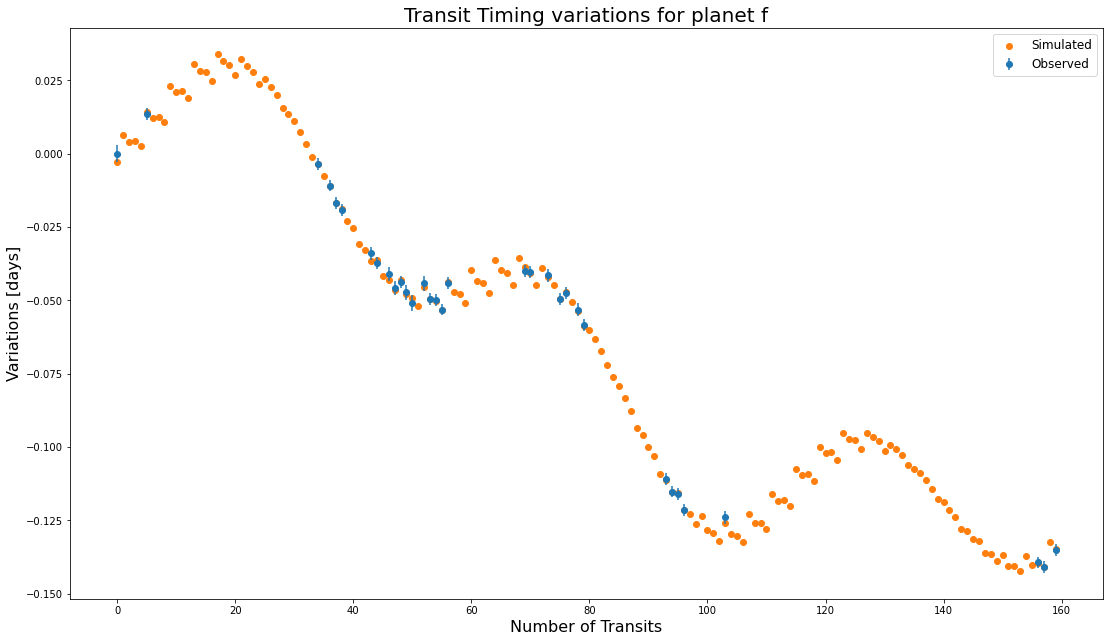

In [40]:
err_f = np.sqrt(observed_transits_err['f']**2 + observed_transits_err['f'][0]**2)
plt.errorbar(np.around((observed_transits['f'] - observed_transits['f'][0])/9.207540), 
            observed_transits['f'] - observed_transits['f'][0] - 
            (np.around((observed_transits['f'] - observed_transits['f'][0])/9.207540)*(9.207540)),
            yerr = err_f, fmt= 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits2['f'])), 
            simulated_transits2['f'] - observed_transits['f'][0] - 
            (np.arange(0, len(simulated_transits2['f']))*(9.207540)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet f", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

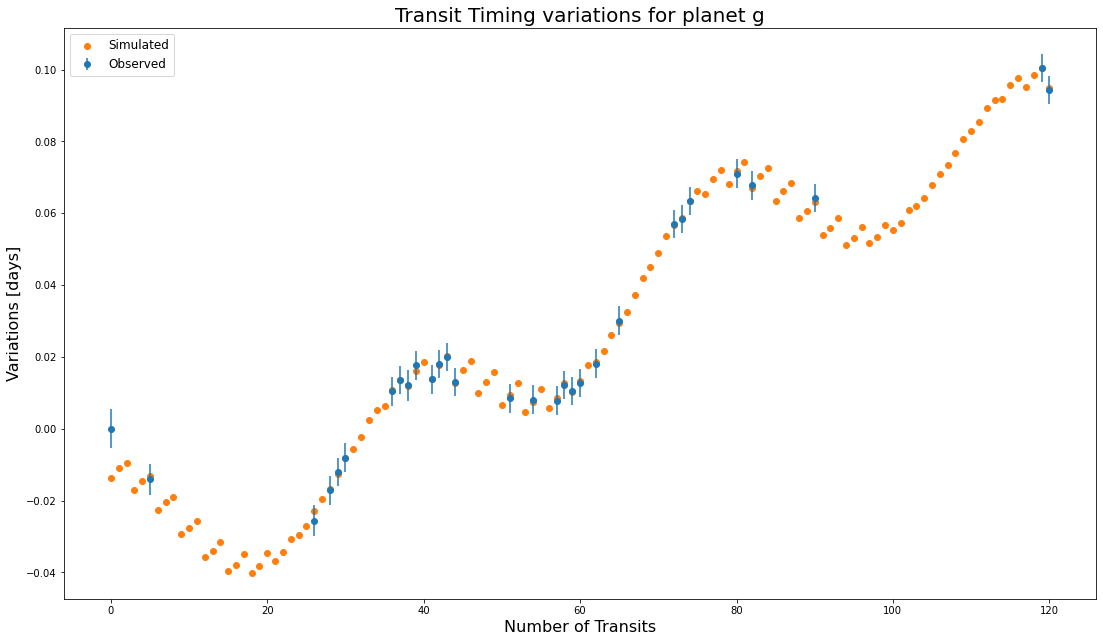

In [41]:
err_g = np.sqrt(observed_transits_err['g']**2 + observed_transits_err['g'][0]**2)
plt.errorbar(np.around((observed_transits['g'] - observed_transits['g'][0])/12.352446), 
            observed_transits['g'] - observed_transits['g'][0] - 
            (np.around((observed_transits['g'] - observed_transits['g'][0])/12.352446)*(12.352446)),
            yerr = err_g, fmt = 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits2['g'])), 
            simulated_transits2['g'] - observed_transits['g'][0] - 
            (np.arange(0, len(simulated_transits2['g']))*(12.352446)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet g", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

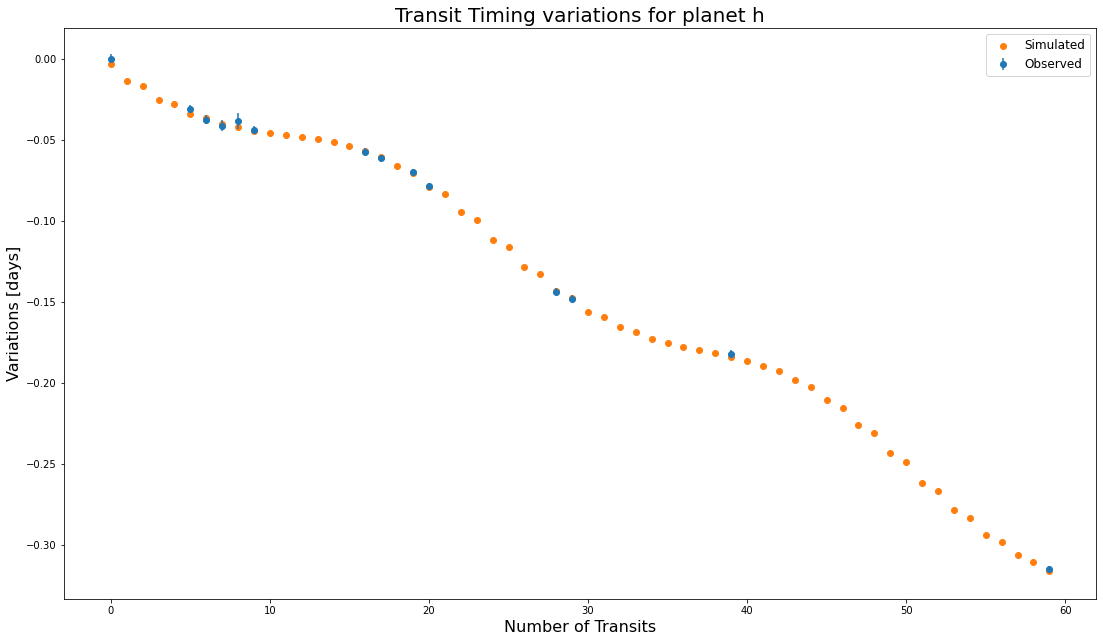

In [42]:
err_h = np.sqrt(observed_transits_err['h']**2 + observed_transits_err['h'][0]**2)
plt.errorbar(np.around((observed_transits['h'] - observed_transits['h'][0])/18.772866), 
            observed_transits['h'] - observed_transits['h'][0] - 
            (np.around((observed_transits['h'] - observed_transits['h'][0])/18.772866)*(18.772866)),
            yerr = err_h, fmt = 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits2['h'])), 
            simulated_transits2['h'] - observed_transits['h'][0] - 
            (np.arange(0, len(simulated_transits2['h']))*(18.772866)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet h", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

### Difference between simulated transits

In [43]:
for key in simulated_transits.keys():
    print('Difference in simulated transits for planet {} in seconds:'.format(key))
    print(np.abs(simulated_transits[key] - simulated_transits2[key])*24*60*60)
    print('-----------------------------------')

Difference in simulated transits for planet b in seconds:
[5.29407553e-02 2.52440921e-02 1.90753624e-01 1.51611105e-01
 5.29127807e-02 1.23667935e-01 1.72143363e-01 3.87400301e-02
 1.93060114e-02 2.72940961e-02 4.13474045e-03 2.92837582e-01
 6.93541457e-02 6.78095705e-02 1.60704265e-01 1.30695375e-01
 2.24853406e-01 8.96867306e-02 9.76748939e-02 9.79493750e-02
 1.05504089e-01 7.75737280e-03 2.16562630e-01 2.22650720e-01
 1.63799938e-01 1.42225312e-01 1.36630077e-01 1.80050824e-01
 1.61362061e-01 2.13373840e-01 2.72420916e-01 8.05417076e-03
 2.45900993e-01 1.65201025e-01 2.02751820e-01 7.39628827e-02
 2.17220347e-01 1.98307630e-01 3.15813610e-02 9.01552266e-02
 1.74165471e-03 1.78322371e-01 2.15873166e-01 4.11329587e-02
 2.36189720e-02 3.11476761e-03 1.26856490e-01 1.44149823e-01
 8.38428678e-02 1.44670889e-01 1.99431879e-01 3.78656667e-02
 6.18019461e-02 1.84828902e-01 9.42745653e-02 2.44503599e-01
 1.50461946e-01 1.35585666e-01 1.72832512e-01 7.40153744e-02
 1.69183320e-01 5.99908264e

#### Planet g -- Starting from the second observed transit

In [44]:
np.absolute(simulated_transits['g'] - observed_transits['g'][1]).argmin()

5

Text(0.5, 0, 'Number of Transits')

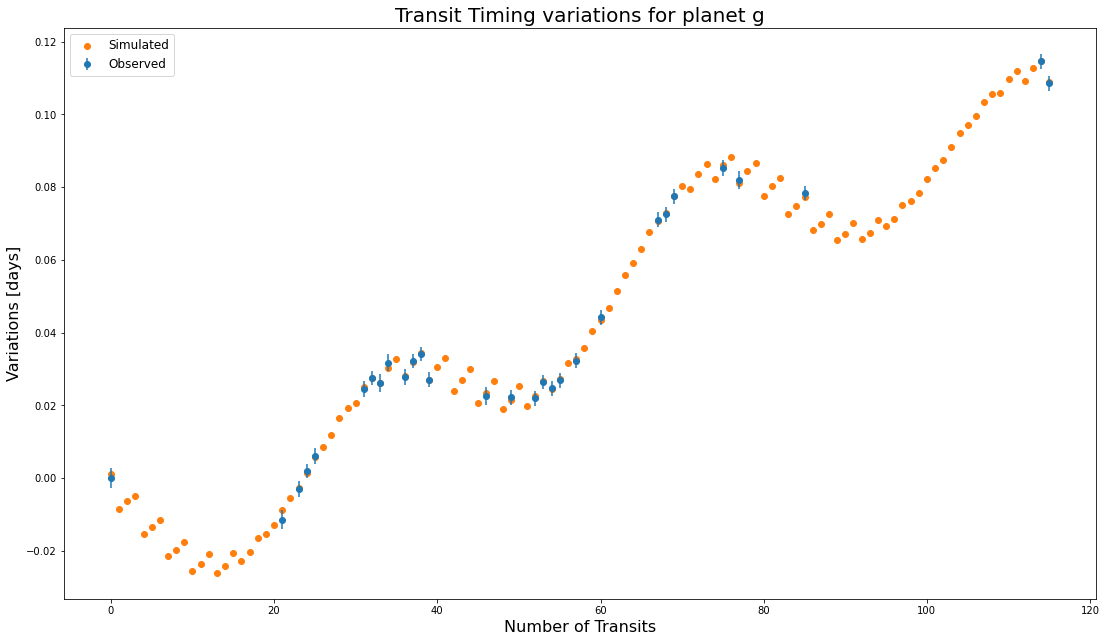

In [45]:
err_g_re = np.sqrt(observed_transits_err['g'][1:]**2 + observed_transits_err['g'][1]**2)
plt.errorbar(np.around((observed_transits['g'][1:] - observed_transits['g'][1])/12.352446), 
            observed_transits['g'][1:] - observed_transits['g'][1] - 
            (np.around((observed_transits['g'][1:] - observed_transits['g'][1])/12.352446)*(12.352446)),
            yerr = err_g_re, fmt = 'o', label = 'Observed')
plt.scatter(np.arange(0, len(simulated_transits2['g'][5:])), 
            simulated_transits2['g'][5:] - observed_transits['g'][1] - 
            (np.arange(0, len(simulated_transits2['g'][5:]))*(12.352446)), color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet g", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

### Difference between observed and simulated transits

In [46]:
for i in range(len(observed_transits['g'])):
    print(np.absolute(simulated_transits['g'] - observed_transits['g'][i])[
        np.absolute(simulated_transits['g'] - observed_transits['g'][i]).argmin()]*24*60)

19.84306640588329
1.465102093789028
4.0234598075039685
0.6249756486795377
0.6488968996563926
0.36391319896210916
0.7730040152091533
0.11873365423525684
0.19915046097594313
2.074147072416963
0.23509845297667198
0.5428431554173585
0.3573889822291676
0.2827007531595882
1.4061570237390697
1.0046403099840973
1.0271901728992816
0.5238554363313597
0.3049811797973234
0.634415021922905
0.5089496111031622
0.9314789742347784
0.4852540035790298
0.45024688413832337
0.06891941302455962
1.2713359185727313
0.8789691797574051
1.496132070897147
0.04045650508487597
0.5798448927816935


In [47]:
# Printing out differences between each of the observed transits and their closest simulated transit in minutes
for key in simulated_transits:
    print('Planet {} transit differences in minutes:'.format(key))
    difference = np.array([])
    for i in range(len(observed_transits[key])):
        index = np.abs(simulated_transits[key] - observed_transits[key][i]).argmin()
        difference = np.append(difference, np.abs(simulated_transits[key][index] - observed_transits[key][i])*24*60)
    print(difference)
    print('\n Transits where difference is more than a minute:')
    print(difference[np.where(difference >= 1)])
    print('---------------------------------------------')

Planet b transit differences in minutes:
[3.70810547e+00 7.33570610e-02 3.69726334e+00 1.37413836e+00
 5.04631695e-02 6.10305330e-01 1.72244365e-01 7.21715829e-01
 4.53537065e-01 2.85180843e-01 2.90045055e-01 4.63618401e-01
 2.07997232e-01 8.38710144e-01 8.82244524e-01 1.30066057e-01
 1.34955214e+00 3.21667247e+00 3.09246214e-01 4.72600689e-01
 2.81036720e+00 1.15113280e+00 1.06181327e-01 5.34984147e-01
 3.70924662e-02 7.00286165e-02 6.36121575e-01 7.49097967e-01
 9.76068429e-01 1.24267636e-01 8.47449675e-02 2.78631674e-01
 1.37785932e+00 7.01153532e-01 2.59128868e-02 2.21341011e-01
 6.74058430e-02 7.13815262e-01 2.00657798e-02 3.37256742e-01
 1.47603910e-01 5.17377911e-02 9.89702334e-01 1.19502469e+00
 1.27284831e-01 2.20104349e-01 5.25617379e-01 1.62294277e+00
 4.11348336e-01 8.10819312e-01 9.09148519e-01 1.40897898e+00
 9.90348184e-01 2.12365419e-01 1.25647849e-01 1.13084800e+00
 1.43977941e-02 5.24742976e-01 4.83372494e-01 9.74096073e-01
 2.78538092e-01 2.07100480e+00 1.91787963e+0

### Removing linear trends

In [48]:
def linear(x, a, b):
    return a*x + b

In [49]:
simulated_remove_trend = {'b' : np.array([]),
                         'c' : np.array([]),
                         'd' : np.array([]),
                         'e' : np.array([]),
                         'f' : np.array([]),
                         'g' : np.array([]),
                         'h' : np.array([])}
for key in key_index.keys():
    period = pl_P[key_index[key]-1] / (2*np.pi/365.25)
    N = len(simulated_transits[key])
    transitvar = simulated_transits[key] - observed_transits[key][0] - (np.arange(0, N)*(period))
    A = np.vstack([range(N), np.ones(N)]).T
    m, c = np.linalg.lstsq(A, transitvar, rcond=-1)[0]
    simulated_remove_trend[key] = np.array(transitvar-m*np.array(range(N))-c)

In [50]:
observed_remove_trend = {'b' : np.array([]),
                         'c' : np.array([]),
                         'd' : np.array([]),
                         'e' : np.array([]),
                         'f' : np.array([]),
                         'g' : np.array([]),
                         'h' : np.array([])}
fit_error = {'b' : np.array([]),
             'c' : np.array([]),
             'd' : np.array([]),
             'e' : np.array([]),
             'f' : np.array([]),
             'g' : np.array([]),
             'h' : np.array([])}
for key in key_index.keys():
    period = pl_P[key_index[key]-1] / (2*np.pi/365.25)
    no_of_transits = np.around((observed_transits[key] - observed_transits[key][0])/period)
    observed_var = observed_transits[key] - observed_transits[key][0] - ((no_of_transits/9.207540)*(9.207540))
    popt, pcov = curve_fit(linear, no_of_transits, observed_var)
    a, b = popt
    fit_error[key] = np.sqrt(np.diag(pcov))
    for i in range(len(no_of_transits)):
        observed_remove_trend[key] = np.append(observed_remove_trend[key], observed_var[i] - a*no_of_transits[i] - b)

Text(0.5, 0, 'Number of Transits')

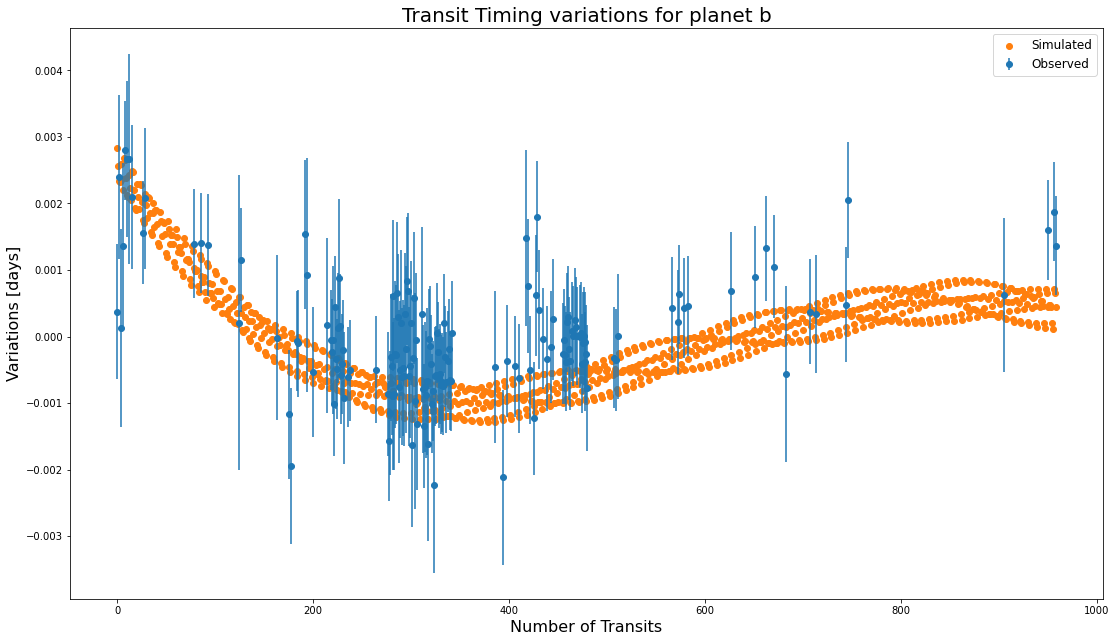

In [51]:
err_b = np.sqrt(observed_transits_err['b']**2 + observed_transits_err['b'][0]**2 + fit_error['b'][0]**2 + 
                fit_error['b'][1]**2)
plt.errorbar(np.around((observed_transits['b'] - observed_transits['b'][0])/1.510826),
            observed_remove_trend['b'], yerr = err_b, fmt = 'o',
            label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['b'])), 
            simulated_remove_trend['b'], color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet b", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

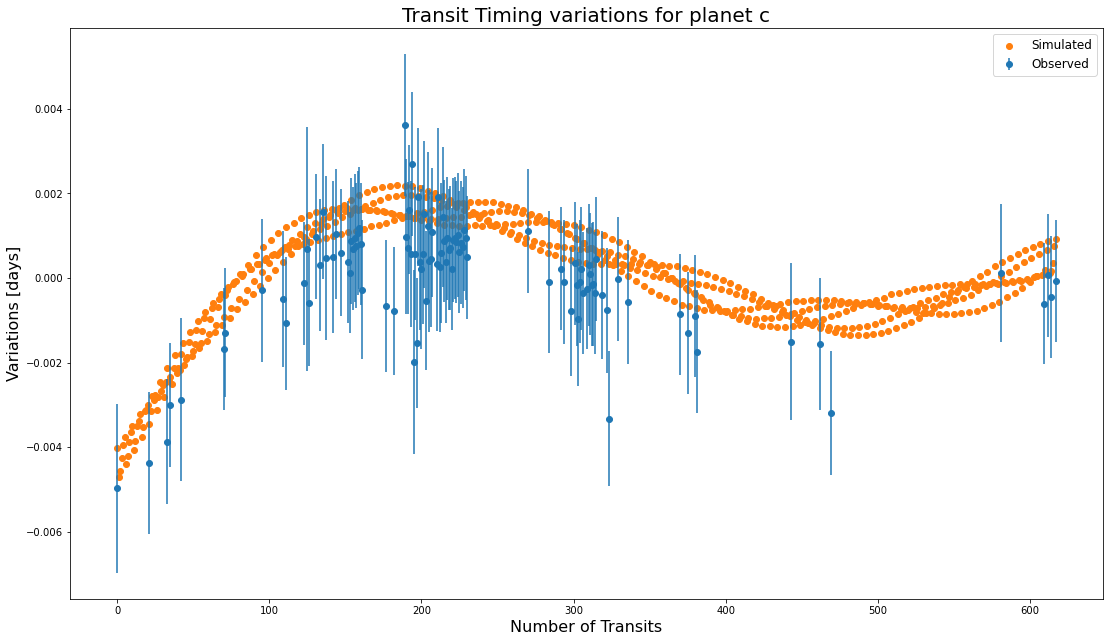

In [52]:
err_c = np.sqrt(observed_transits_err['c']**2 + observed_transits_err['c'][0]**2 + fit_error['c'][0]**2 + 
                fit_error['c'][1]**2)
plt.errorbar(np.around((observed_transits['c'] - observed_transits['c'][0])/2.421937),
            observed_remove_trend['c'], yerr = err_c, fmt = 'o',
            label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['c'])), 
            simulated_remove_trend['c'], color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet c", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

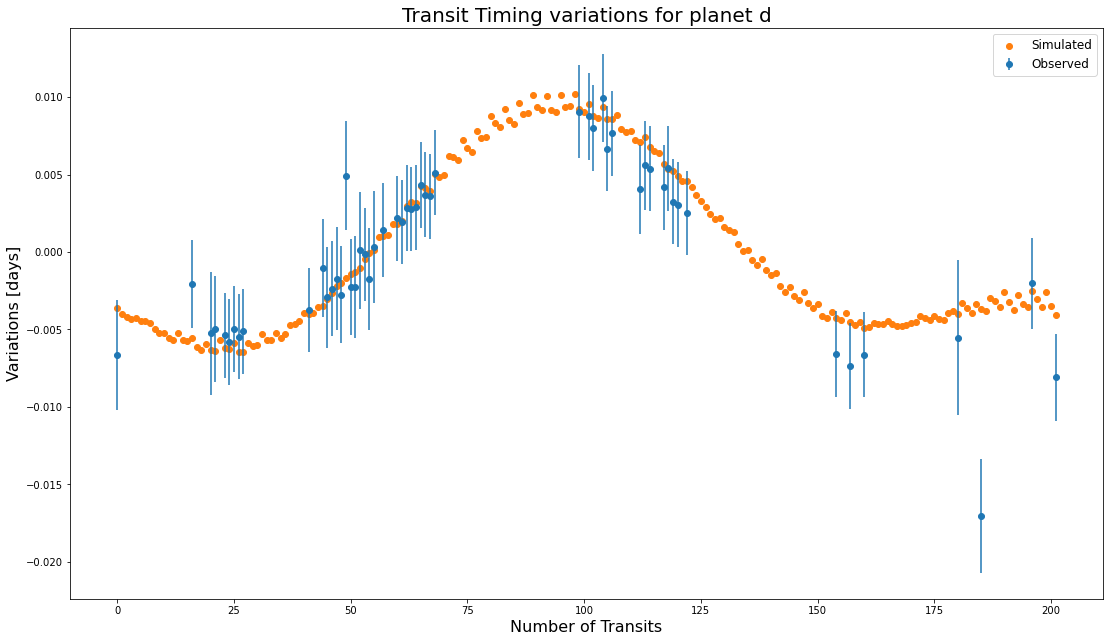

In [53]:
err_d = np.sqrt(observed_transits_err['d']**2 + observed_transits_err['d'][0]**2 + fit_error['d'][0]**2 + 
                fit_error['d'][1]**2)
plt.errorbar(np.around((observed_transits['d'] - observed_transits['d'][0])/4.049219),
            observed_remove_trend['d'], yerr = err_d, fmt = 'o',
            label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['d'])), 
            simulated_remove_trend['d'], color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet d", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

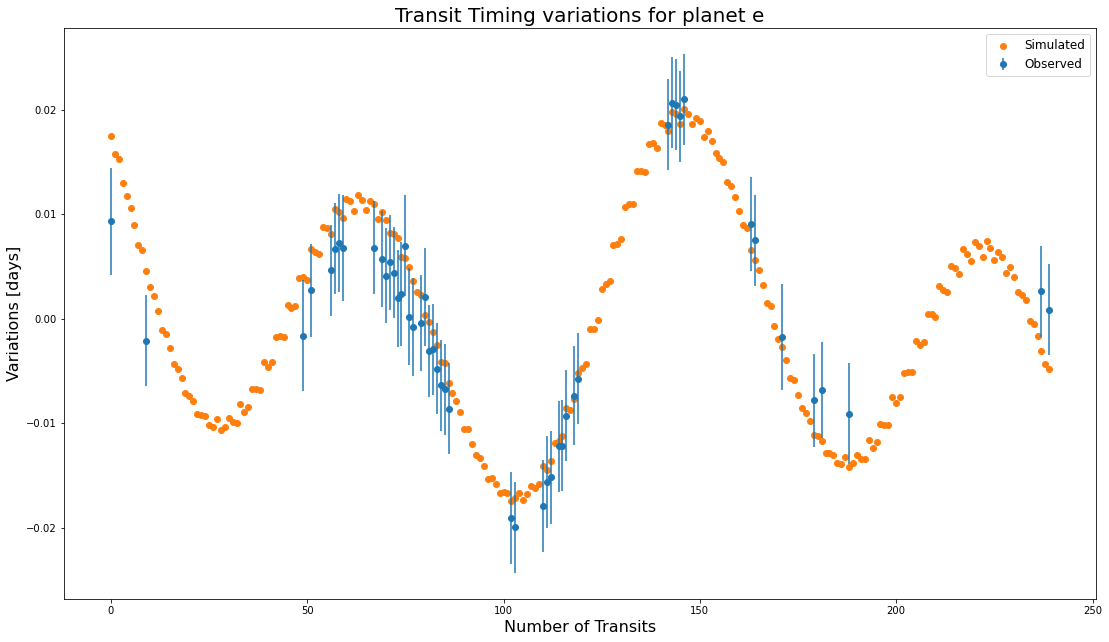

In [54]:
err_e = np.sqrt(observed_transits_err['e']**2 + observed_transits_err['e'][0]**2 + fit_error['e'][0]**2 + 
                fit_error['e'][1]**2)
plt.errorbar(np.around((observed_transits['e'] - observed_transits['e'][0])/6.101013),
            observed_remove_trend['e'], yerr = err_e, fmt = 'o',
            label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['e'])), 
            simulated_remove_trend['e'], color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet e", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

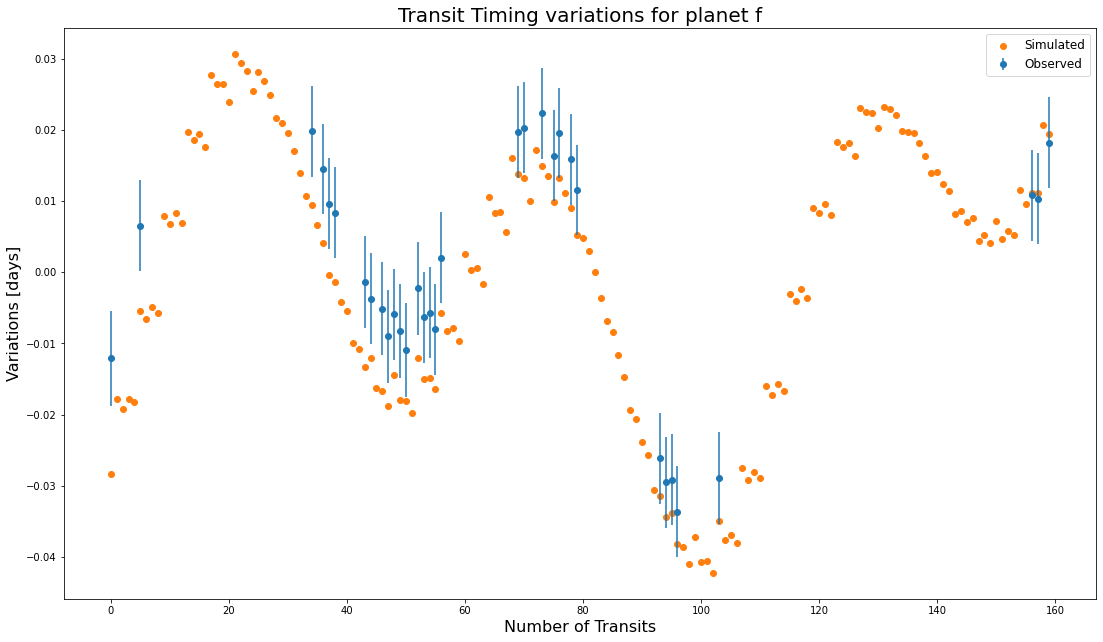

In [55]:
err_f = np.sqrt(observed_transits_err['f']**2 + observed_transits_err['f'][0]**2 + fit_error['f'][0]**2 + 
                fit_error['f'][1]**2)
plt.errorbar(np.around((observed_transits['f'] - observed_transits['f'][0])/9.207540),
            observed_remove_trend['f'], yerr = err_f, fmt = 'o',
            label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['f'])), 
            simulated_remove_trend['f'], color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet f", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

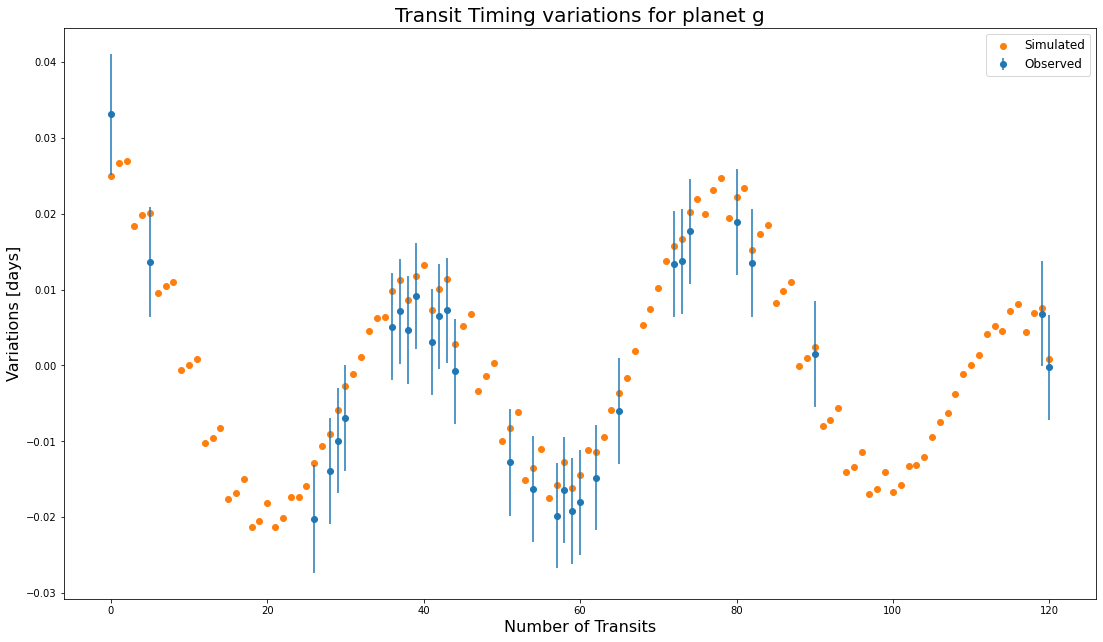

In [56]:
err_g = np.sqrt(observed_transits_err['g']**2 + observed_transits_err['g'][0]**2 + fit_error['g'][0]**2 + 
                fit_error['g'][1]**2)
plt.errorbar(np.around((observed_transits['g'] - observed_transits['g'][0])/12.352446),
            observed_remove_trend['g'], yerr = err_g, fmt = 'o',
            label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['g'])), 
            simulated_remove_trend['g'], color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet g", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

Text(0.5, 0, 'Number of Transits')

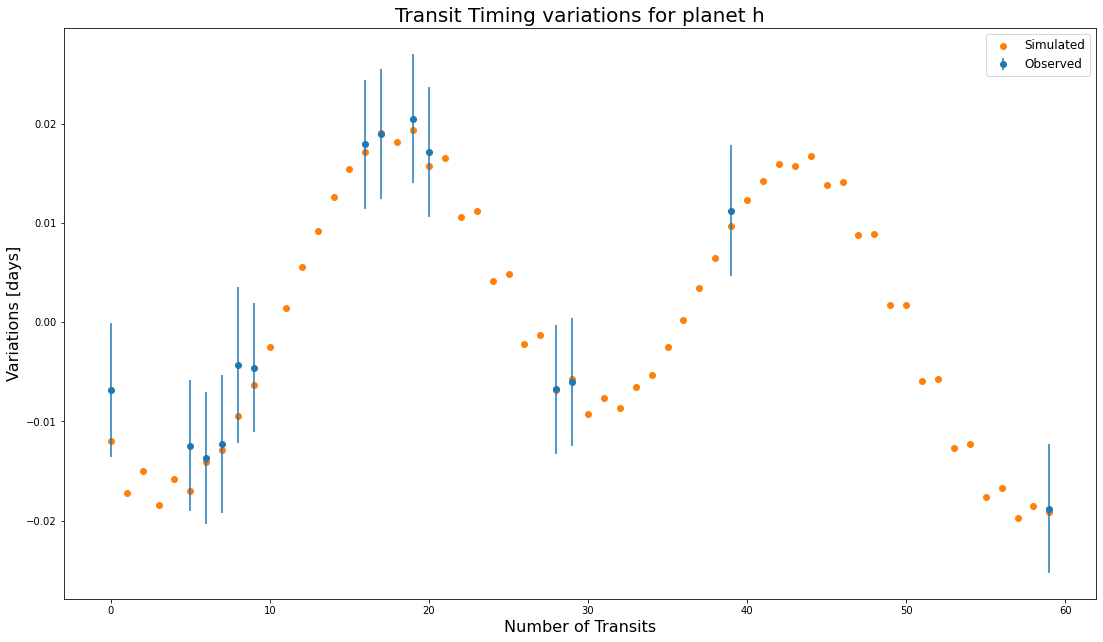

In [57]:
err_h = np.sqrt(observed_transits_err['h']**2 + observed_transits_err['h'][0]**2 + fit_error['h'][0]**2 + 
                fit_error['h'][1]**2)
plt.errorbar(np.around((observed_transits['h'] - observed_transits['h'][0])/18.772866),
            observed_remove_trend['h'], yerr = err_h, fmt = 'o',
            label = "Observed")
plt.scatter(np.arange(0, len(simulated_transits['h'])), 
            simulated_remove_trend['h'], color = 'C1', label = 'Simulated')
plt.legend(fontsize = 12)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title("Transit Timing variations for planet h", fontsize=20)
ax.set_ylabel("Variations [days]", fontsize=16)
ax.set_xlabel("Number of Transits", fontsize=16)

### Plotting the riverplot

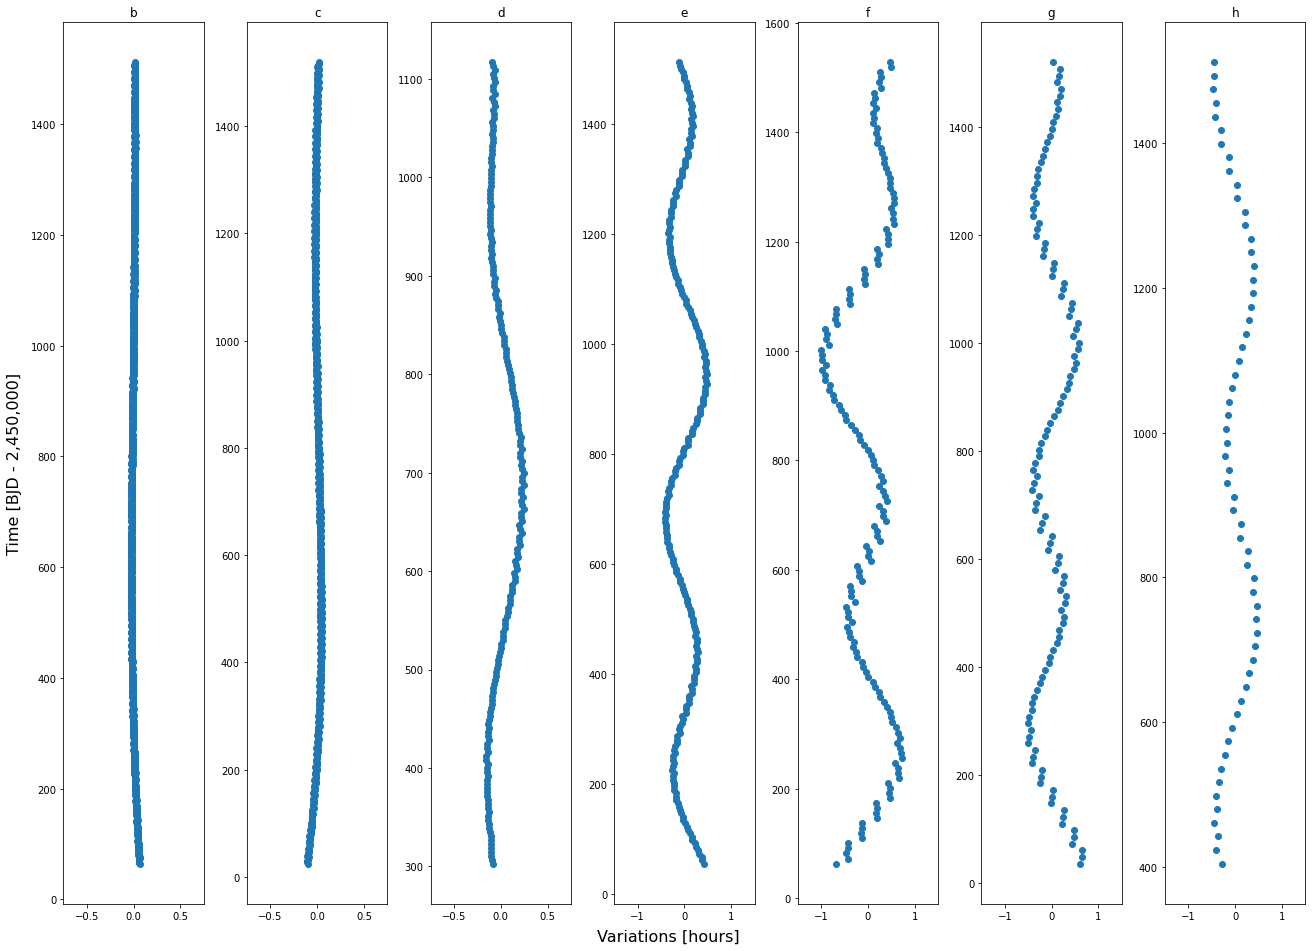

In [58]:
fig, ax = plt.subplots(1, len(key_index),figsize=(18,13)) # sharey = True)
START = start_t/(2*np.pi/365.25)
for i, k in enumerate(key_index):
    period = pl_P[i] / (2*np.pi/365.25)
    ax[i].set_title(k)
    ax[i].scatter(simulated_remove_trend[k]*24, 
                  simulated_transits[k] - START)
    if i in range(3):
        ax[i].set_xlim(-0.75, 0.75)
    else:
        ax[i].set_xlim(-1.5, 1.5)
fig.text(0.5, -0.01, "Variations [hours]", fontsize=16, ha='center')
fig.text(-0.01, 0.5, "Time [BJD - 2,450,000]", fontsize=16, va='center', rotation='vertical')
fig.tight_layout()

## Improved Bisection Method

### Transits of Planet b using Bisection Method

In [59]:
sim_b_bm  = np.array([])
sim_start = (observed_transits['b'][0] - 0.2) * (2*np.pi/365.25)
transittimes = np.zeros(1 + round((observed_transits['b'][len(observed_transits['b'])-1] - 
                                       observed_transits['b'][0])/(pl_P[key_index['b']-1]/(2*np.pi/365.25))))
counter_per_transit_bm = np.zeros(len(transittimes))
sim.integrate(sim_start)
p = sim.particles
i = 0
while i < len(transittimes):
    y_old = p[key_index['b']].y - p[0].y 
    t_old = sim.t
    sim.integrate(sim.t + (0.06*(2*np.pi/365.25))) 
    t_new = sim.t
    if y_old*(p[key_index['b']].y - p[0].y) < 0. and p[key_index['b']].x - p[0].x > 0.:   
        # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new - t_old > 1e-07:
            if y_old*(p[key_index['b']].y - p[0].y) < 0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate((t_new + t_old)/2.)
            counter_per_transit_bm[i] += 1
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t + (0.06*(2*np.pi/365.25)))
sim_b_bm = transittimes / (2*np.pi/365.25) 

In [60]:
print('Using Bisection Method:')
print(sim_b_bm)

Using Bisection Method:
[7322.51788507 7324.02849604 7325.53915094 7327.05001459 7328.56116754
 7330.0718371  7331.58255426 7333.09390863 7334.60476496 7336.11538324
 7337.62601618 7339.13686884 7340.64808039 7342.15876459 7343.66947077
 7345.18078119 7346.6916485  7348.20226679 7349.71288507 7351.22373407
 7352.73500055 7354.2456994  7355.75639826 7357.26765375 7358.77852472
 7360.28915399 7361.79976496 7363.31061029 7364.82192804 7366.33263788
 7367.84332575 7369.35452631 7370.86540094 7372.37605219 7373.88665949
 7375.3974975  7376.90885553 7378.41958368 7379.9302569  7381.44140253
 7382.95228449 7384.46295404 7385.97356134 7387.48439203 7388.99578668
 7390.50652948 7392.01719904 7393.52828241 7395.03916071 7396.54986689
 7398.06047419 7399.57129755 7401.08272516 7402.59348261 7404.10413752
 7405.61515863 7407.12604059 7408.63678339 7410.14740534 7411.65821772
 7413.16965998 7414.68043573 7416.19108332 7417.70204218 7419.21292414
 7420.72371454 7422.23434015 7423.74514154 7425.25659

In [61]:
print(counter_per_transit_bm)

[15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15

### Using Improved (?) Bisection Method

In [62]:
def func(y2, y1, x2, x1):
    m = (y2-y1)/(x2-x1)
    b = y1 - (m*x1)
    return m, b

In [63]:
sim_b_ibm  = np.array([])
sim_start = (observed_transits['b'][0] - 0.2) * (2*np.pi/365.25)
transittimes = np.zeros(1 + round((observed_transits['b'][len(observed_transits['b'])-1] - 
                                       observed_transits['b'][0])/(pl_P[key_index['b']-1]/(2*np.pi/365.25))))
counter_per_transit_ibm = np.zeros(len(transittimes))
sim.integrate(sim_start)
p = sim.particles
i = 0
while i < len(transittimes):
    y_old = p[key_index['b']].y - p[0].y 
    t_old = sim.t
    sim.integrate(sim.t + (0.006*(2*np.pi/365.25))) 
    t_new = sim.t
    if y_old*(p[key_index['b']].y - p[0].y) < 0. and p[key_index['b']].x - p[0].x > 0.:   
        # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new - t_old > 1e-07:
            m, b = func(p[key_index['b']].y - p[0].y, y_old, t_new, t_old)
            if y_old*(p[key_index['b']].y - p[0].y) < 0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate(-b/m)
            counter_per_transit_ibm[i] += 1
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t + (0.006*(2*np.pi/365.25)))
sim_b_ibm = transittimes / (2*np.pi/365.25) 

In [64]:
sim_b_ibm

array([7322.51805805, 7324.02870394, 7325.53935731, 7327.05017058,
       7328.56125653, 7330.07200983, 7331.5827362 , 7333.09397071,
       7334.60489119, 7336.11557621, 7337.62622282, 7339.13702793,
       7340.64816098, 7342.1589317 , 7343.6696534 , 7345.18085178,
       7346.69177359, 7348.2024602 , 7349.71309596, 7351.22389416,
       7352.73507155, 7354.24586188, 7355.75658022, 7357.26773233,
       7358.77865205, 7360.28934683, 7361.79997783, 7363.31077215,
       7364.82199213, 7366.33279661, 7367.8435096 , 7369.35461409,
       7370.86552989, 7372.37623913, 7373.88687252, 7375.39765947,
       7376.9089143 , 7378.41973556, 7379.93044361, 7381.44149956,
       7382.952412  , 7384.46313684, 7385.97377301, 7387.48455561,
       7388.99584073, 7390.50667917, 7392.0173858 , 7393.52838847,
       7395.03929179, 7396.55003984, 7398.06068364, 7399.57146295,
       7401.08277553, 7402.5936275 , 7404.10432799, 7405.61527899,
       7407.12617299, 7408.63695031, 7410.14760809, 7411.65838

In [65]:
counter_per_transit_ibm

array([186., 160., 162., 206., 324., 188., 180., 426., 244., 170., 160.,
       204., 352., 192., 178., 398., 244., 170., 158., 202., 382., 198.,
       178., 364., 244., 172., 156., 200., 414., 204., 176., 334., 242.,
       176., 156., 198., 444., 208., 176., 308., 242., 180., 158., 196.,
       470., 214., 174., 280., 238., 186., 160., 196., 496., 218., 174.,
       258., 234., 194., 162., 194., 512., 224., 172., 236., 232., 204.,
       166., 192., 522., 228., 172., 220., 226., 218., 168., 192., 526.,
       234., 170., 204., 222., 232., 174., 190., 516., 238., 170., 192.,
       218., 250., 178., 188., 502., 240., 170., 182., 214., 270., 184.,
       188., 482., 244., 170., 174., 210., 294., 190., 186., 454., 246.,
       170., 168., 208., 322., 194., 184., 424., 248., 172., 164., 204.,
       348., 200., 182., 392., 250., 174., 160., 202., 380., 206., 182.,
       360., 250., 176., 158., 200., 414., 212., 180., 330., 248., 180.,
       158., 198., 442., 216., 178., 302., 248., 18

Text(0.5, 0, 'Number of Tranisits')

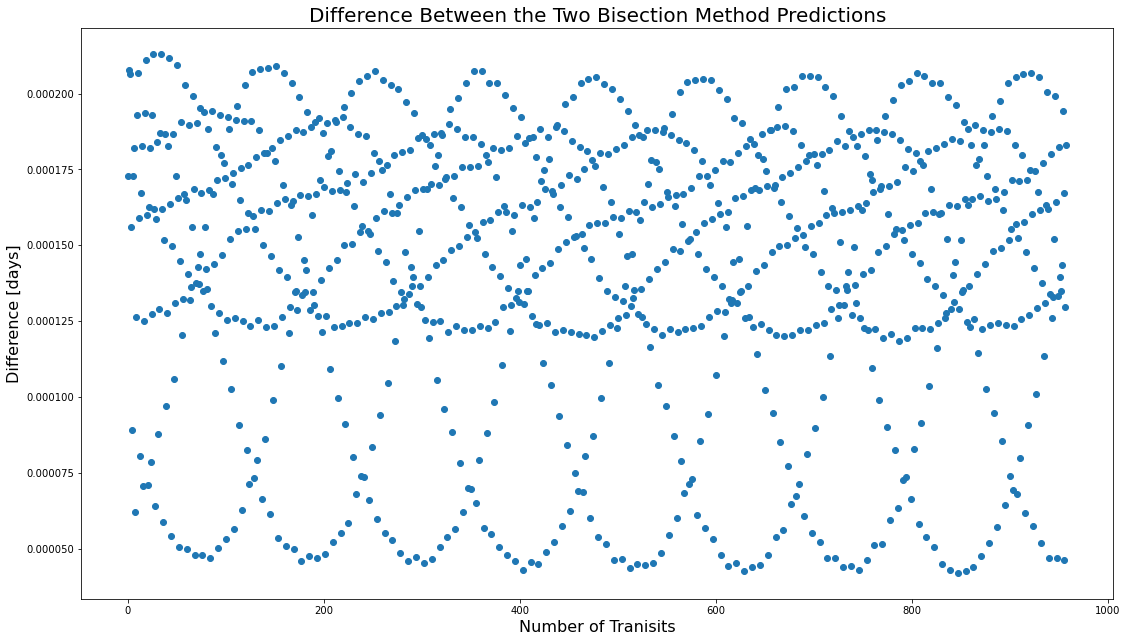

In [66]:
plt.scatter(np.arange(0, len(sim_b_bm)), sim_b_ibm - sim_b_bm)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = plt.gca()
ax.set_title('Difference Between the Two Bisection Method Predictions', fontsize = 20)
ax.set_ylabel('Difference [days]', fontsize = 16)
ax.set_xlabel('Number of Tranisits', fontsize = 16)

In [67]:
print('Difference in seconds:')
print((sim_b_ibm - sim_b_bm)*24*60*60)
print('Maximum difference = {}'.format(np.max((sim_b_ibm - sim_b_bm)*24*60*60)))
print('Minimum difference = {}'.format(np.min((sim_b_ibm - sim_b_bm)*24*60*60)))

Difference in seconds:
[14.9450331  17.96279728 17.82987085 13.47723309  7.68855552 14.92347285
 15.71923618  5.36371036 10.90637213 16.67225731 17.85402786 13.74568907
  6.9635002  14.43802566 15.7796544   6.09900328 10.80731328 16.71082391
 18.22069639 13.83132153  6.1341958  14.03764176 15.72163107  6.78970147
 11.00122528 16.66115328 18.39203847 13.98461567  5.53718582 13.71449614
 15.88528131  7.58466319 11.14106324 16.15221347 18.40611347 13.99448937
  5.0775503  13.1224221  16.13135558  8.38300152 11.01733001 15.79350505
 18.28812658 14.13337706  4.66986944 12.93268412 16.13587575  9.16378106
 11.32505267 14.94309146 18.09711403 14.29104254  4.35174383 12.51882504
 16.4572842  10.39847736 11.43944931 14.42191787 17.51783138 14.24174689
  4.29963336 12.12985596 16.393785   11.39326528 11.7774434  13.48219111
 17.21584586 14.54672042  4.1355723  11.87497488 16.42652739 12.32914812
 11.8650736  12.71499552 16.85748446 14.45239219  4.14239268 11.66268655
 16.74097598 13.47313654 12.

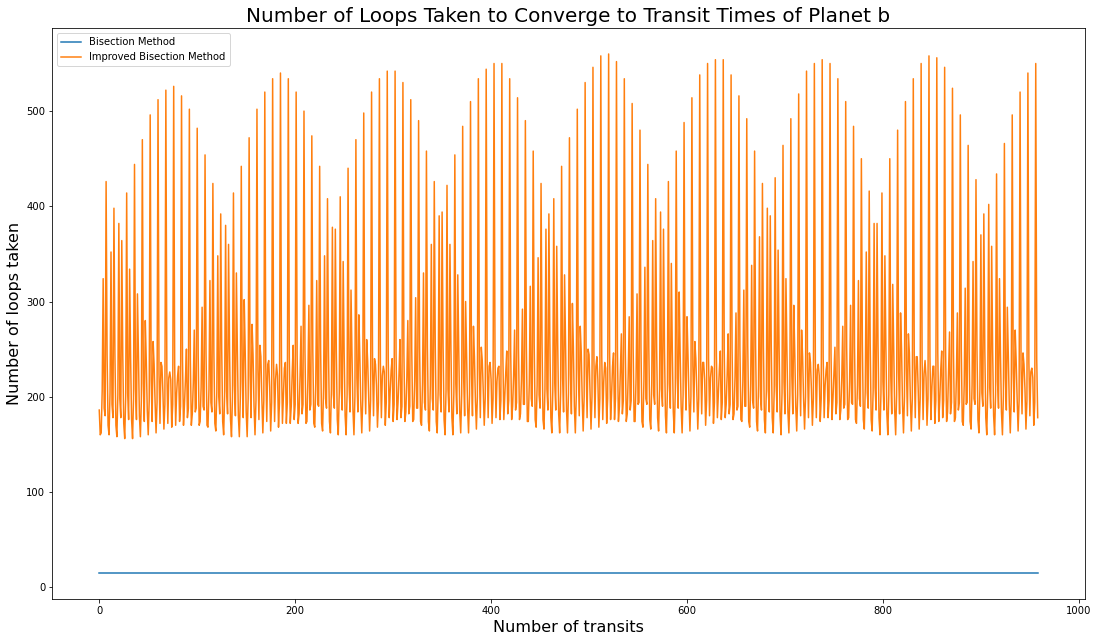

In [68]:
plt.plot(np.arange(0, len(sim_b_bm)), counter_per_transit_bm, label = 'Bisection Method')
plt.plot(np.arange(0, len(sim_b_bm)), counter_per_transit_ibm, label = 'Improved Bisection Method')
plt.legend(loc = 'best')
plt.title('Number of Loops Taken to Converge to Transit Times of Planet b', fontsize = 20)
plt.xlabel('Number of transits', fontsize = 16)
plt.ylabel('Number of loops taken', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)